# Introduction - Real or Not? NLP with Disaster Tweets

* Link of the Competition - https://www.kaggle.com/c/nlp-getting-started

Real or Not? NLP with Twitter
As a Datascience newcomer, I decided to write this notebook to extend my knowledge about natural language processing (NLP), in this notebook, we will be analyzing 10,000 hand classified tweets. these tweets are either labeled as disasters or not disasters. For instance we can consider the 2 following tweets:


*   These boxes are ready to explode! Exploding Kittens finally arrived! (Not Disaster)
*   Forest fire near La Ronge Sask. Canada (Disaster)

So this kernel aim's at predicting the correct label. We will go through **data analysis**, **cleaning and text processing**, **feature engineering**, word embedding with **glove** and we will finally make 3 differents DL models:


*   **Simple** Neural Network with text input
*   **Mixed Data** Neural Network with text input + metadata input
*   Neural Network with **Bert** pretrained layer


Please note that this is my first notebook published on Kaggle, any advice would be highly appreciated, do not hesitate if you have any idea to improve this kernel, feel free to ask questions aswell.   



# Install dependencies, Import Libraries and datasets

In [ ]:
!pip install glove_python
!pip install -U pip setuptools wheel
!pip install -U spacy
!pip install textblob
#!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_sm
!pip install tensorflow-addons
!pip install wordcloud 
from tqdm import tqdm
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import tensorflow_addons as tfa
import sys, os, re, csv, codecs
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


#spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report


     |████████████████████████████████| 266kB 6.8MB/s 
  ERROR: Failed building wheel for glove-python
  Running setup.py clean for glove-python
  ERROR: Failed cleaning build dir for glove-python
Failed to build glove-python
    Running setup.py install for glove-python ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-a1op0gug/glove-python/setup.py'"'"'; __file__='"'"'/tmp/pip-install-a1op0gug/glove-python/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-r6vxq124/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
     |████████████████████████████████| 1.5MB 6.3MB/s 
     |████████████████████████████████| 788kB 21.2MB/s 
Requirement already up-to-date: wheel in /usr/local/li

     |████████████████████████████████| 12.7 MB 246 kB/s 
     |████████████████████████████████| 456 kB 56.5 MB/s 
     |████████████████████████████████| 9.1 MB 61.7 MB/s 
     |████████████████████████████████| 1.1 MB 61.3 MB/s 
     |████████████████████████████████| 113 kB 72.4 MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-py3-none-any.whl size=107097 sha256=d25d541457899b783441a299242a32d8a88b7c5b18ce97d44f81153db6f0e288
  Stored in directory: /root/.cache/pip/wheels/83/a6/12/bf3c1a667bde4251be5b7a3368b2d604c9af2105b5c1cb1870
Successfully built smart-open
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: smart-open
    Found existing installation: smart-open 4.2.0
    Uninstalling 

We load the files

In [ ]:
df_train = pd.read_csv('/content/dataset/train.csv')
df_test = pd.read_csv('/content/dataset/test.csv')
sample_submission = pd.read_csv('/content/dataset/sample_submission.csv')

# Keyword and Location Analysis


## I - Visualization 

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


There are some missing values in both keyword and location columns so we fill them respectively with 'unknown' and 'unlocated'

In [ ]:
# we fill missing values them with respectively 'unknown' and 'unlocated'
df_train['keyword'] = df_train['keyword'].fillna('unknown')
df_train['location'] = df_train['location'].fillna('unlocated')

#on test
df_test['keyword'] = df_test['keyword'].fillna('unknown')
df_test['location'] = df_test['location'].fillna('unlocated')

In [ ]:
df_train['keyword'].value_counts()[0:20]

unknown        61
fatalities     45
deluge         42
armageddon     42
sinking        41
harm           41
damage         41
body%20bags    41
windstorm      40
fear           40
outbreak       40
evacuate       40
siren          40
collided       40
twister        40
derailment     39
collision      39
whirlwind      39
explosion      39
hellfire       39
Name: keyword, dtype: int64

Now, we want to know if keywords have an impact on the target, let's take the 20 most frequent keywords, we could have taken more but we want to keep it readable on the graph 

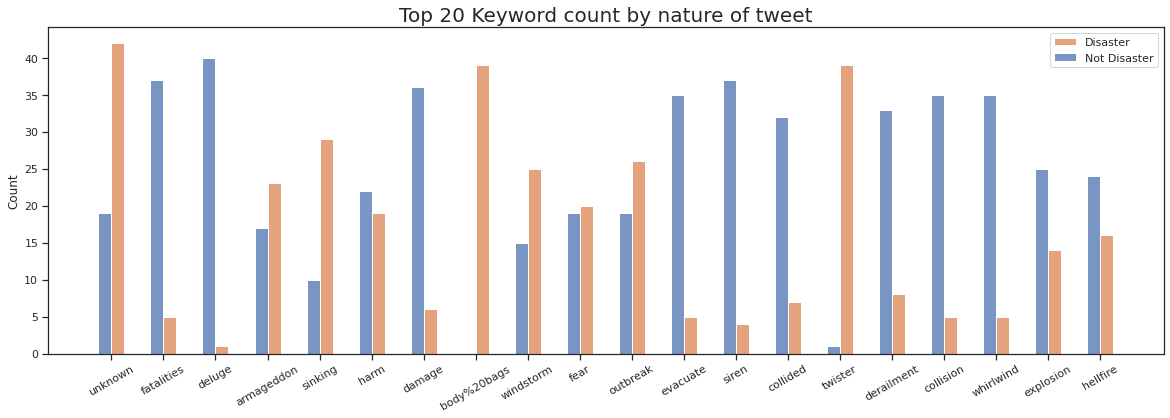

In [ ]:
#Let's take the 20 most frequent keywords
top20 = df_train['keyword'].value_counts()[0:20].index.tolist()
#We take all the keywords and targets if they are in the top20 list
df_top20 = [(keyword,target) for keyword,target in zip(df_train['keyword'], df_train['target']) if keyword in top20]
df_top20 = pd.DataFrame(df_top20, columns = ['keyword', 'target'])

#We plot the results to see the impact of keywords on target
sns.set_theme(style="ticks")
fig, ax = plt.subplots(1,1, figsize = (20,6))
g = sns.histplot(data = df_top20, x = 'keyword', hue = 'target', multiple = 'dodge', shrink = 0.5, ax = ax)
g.set_xticklabels(labels = top20, rotation=30)
g.set_xlabel('')
g.set_title('Top 20 Keyword count by nature of tweet', fontsize=20)
g.legend(['Disaster','Not Disaster'],loc="upper right")

plt.show()

As we can see, some keywords are more frequently used to describe disasters than others (unknown/no keywords, windstorm, wrecked...) so it is an important feature to keep in our model. Now let's take a look at the location column

In [ ]:
df_train['location'].value_counts()[0:20]

unlocated          2533
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Mumbai               22
Washington, DC       21
Kenya                20
Worldwide            19
Australia            18
Chicago, IL          18
California           17
California, USA      15
Everywhere           15
New York, NY         15
Name: location, dtype: int64

there are a lot of tweets without a location: 2533 so we won't get a proprer scale to visualize the graph if we keep every location together.
So we are going to visualize "unlocated" and the rest of the locations separatly



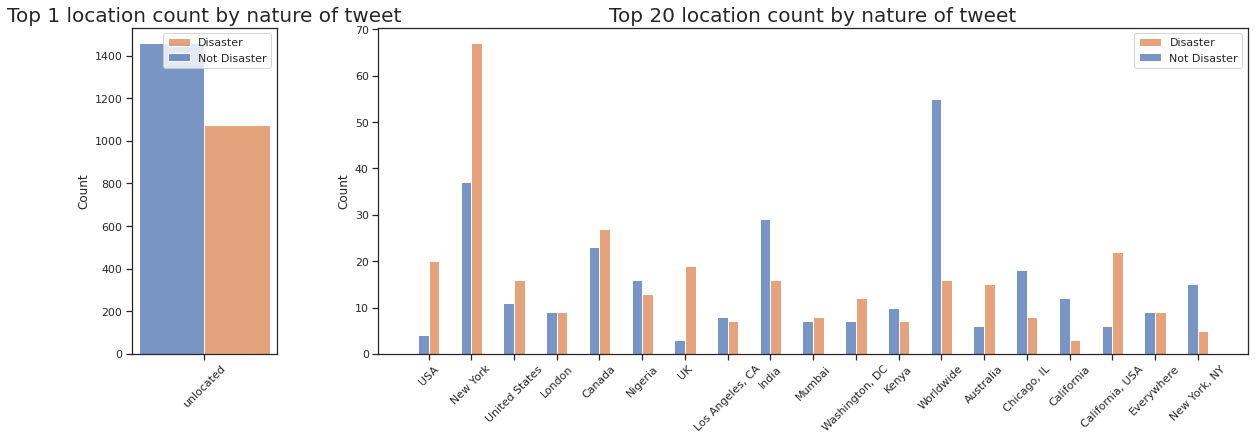

In [ ]:
#Let's take the keyword "unlocated" and process the data separatly from the other keywords
df_top1 = [(keyword,target) for keyword,target in zip(df_train['location'], df_train['target']) if keyword == 'unlocated']
df_top1 = pd.DataFrame(df_top1, columns = ['location', 'target'])

#Let's take the rest of the 20 most frequent keywords
top20 = df_train['location'].value_counts()[1:20].index.tolist()
#We take all the keywords and targets if they are in the top20 list
df_top20 = [(keyword,target) for keyword,target in zip(df_train['location'], df_train['target']) if keyword in top20]
df_top20 = pd.DataFrame(df_top20, columns = ['location', 'target'])

sns.set_theme(style="ticks")

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,6), gridspec_kw={'width_ratios': [1, 6]})

g1 = sns.histplot(data = df_top1, x = 'location', hue = 'target', multiple = 'dodge', shrink = 0.5, ax = ax1)
g1.set_xticklabels(labels = ["unlocated"], rotation = 45)
g1.set_xlabel('')
g1.set_title('Top 1 location count by nature of tweet', fontsize=20)
g1.legend(['Disaster','Not Disaster'],loc="upper right")

g20 = sns.histplot(data = df_top20, x = 'location', hue = 'target', multiple = 'dodge', shrink = 0.5, ax = ax2)
g20.set_xticklabels(labels = top20, rotation=45)
g20.set_xlabel('')
g20.set_title('Top 20 location count by nature of tweet', fontsize=20)
g20.legend(['Disaster','Not Disaster'],loc="upper right")


plt.show()

Several things to say here :


*   It might be usefull to include location in our model but as most of the tweets are unlocated we wonder if this will work well. In fact keeping the location "unlocated" might even worsen the model, later we will keep all the most used locations and remove the location "unlocated" 
*   It seems that the location has an impact on the target aswell, even if it looks less neat than for the keywords
*   Location is not consistent as we can see for example "USA" and "United States" or "California" and "California, USA", beeing used at the same time, we might have to clean it a bit if we want to use this feature wisely.



## II - Cleaning the location feature

In [ ]:
#let's display the unique locations 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None):
  display(pd.DataFrame(df_train['location'].unique(), columns=['location']).sort_values(by='location'))
    

,location
3020,
3335,Glasgow
933,"Melbourne, Australia"
1373,News
1811,å_
...,...
1993,å_: ?? ÌÑ ? : ?
3043,å_å_Los Mina Cityã¢
3103,å¡å¡Midwest Û¢Û¢
3177,åÊ(?Û¢`?Û¢å«)??


After seeing that there are duplicates, miss spelled words, use of abbreviations and other things leading to inconsistency, let's try to clean up the most part. We will then create a function using regex

In [ ]:
  def correct_location(x):
    #special char
    x = re.sub(r"United States", "USA", x)
    x = re.sub(r"America", "USA", x)
    x = re.sub(r"America [|] New Zealand ", "USA", x)
    x = re.sub(r"Americas Newsroom", "USA", x)
    x = re.sub(r"us", "USA", x)
    x = re.sub(r"us-east-1a", "USA", x)

    x = re.sub(r"Los Angeles, CA", "Los Angeles", x)
    x = re.sub(r"Chicago, IL", "Chicago", x)

    x = re.sub(r"Boston MA", "Boston", x)
    x = re.sub(r"Boston MA", "Boston", x)
    x = re.sub(r"Boston [\]x89Û¢ Cape Cod [?]", "Boston", x)
    x = re.sub(r"Boston, MA", "Boston", x)
    x = re.sub(r"Boston, Massachusetts", "Boston", x)
    x = re.sub(r"Boston/Montreal ", "Boston", x)

    x = re.sub(r"Birmingham [&] Bristol", "Birmingham", x)
    x = re.sub(r"Birmingham UK", "Birmingham", x)
    x = re.sub(r"Birmingham and the Marches", "Birmingham", x)
    x = re.sub(r"Birmingham, England", "Birmingham", x)
    x = re.sub(r"Birmingham, UK ", "Birmingham", x)
    x = re.sub(r"Birmingham, United Kingdom", "Birmingham", x)

    x = re.sub(r"California, USA", "California", x)
    x = re.sub(r"California, United States", "California", x)
    x = re.sub(r"California or Colorado", "California", x)
    

    x = re.sub(r"New York, NY", "New York", x)
    x = re.sub(r"New York City", "New York", x)
    x = re.sub(r"New York, USA", "New York", x)
    x = re.sub(r"NY", "New York", x)
    x = re.sub(r"new york", "New York", x)
    x = re.sub(r"nc", "New York", x)
    x = re.sub(r"nyc", "New York", x)

    x = re.sub(r"Florida Forever", "Florida", x)
    x = re.sub(r"Florida USA", "Florida", x)
    x = re.sub(r"Florida but I wanna be n Texas", "Florida", x)
    x = re.sub(r"Florida, USA", "Florida", x)
    x = re.sub(r"Florida, USA", "Florida", x)

    x = re.sub(r"Dallas, TX", "Dallas", x)
    x = re.sub(r"Dallas, TX ", "Dallas", x)
    x = re.sub(r"Dallas, Tejas", "Dallas", x)
    x = re.sub(r"Dallas, Texas[.] ", "Dallas", x)

    x = re.sub(r"England ", "England", x)
    x = re.sub(r"England [&] Wales Border, UK", "England", x)
    x = re.sub(r"England, Great Britain[.]", "England", x)
    x = re.sub(r"England, United Kingdom", "England", x)
    x = re.sub(r"England,UK,Europe,Sol 3[.]", "England", x)
    x = re.sub(r"England[.]", "England", x)
    x = re.sub(r"English Midlands", "England", x)

    x = re.sub(r"Texas, USA", "Texas", x)
    x = re.sub(r"Lagos, Nigeria", "Nigeria", x)
    x = re.sub(r"Nxgerxa", "Lagos", x)

    x = re.sub(r"Tampa, FL", "Tampa", x)
    x = re.sub(r"Florida, USA", "Florida", x)
    x = re.sub(r"Asheville, NC", "Asheville", x)
    x = re.sub(r"Oklahoma City, OK ", "Oklahoma City", x)

    x = re.sub(r"Melbourne, Australia", "Australia", x)
    x = re.sub(r"Adelaide", "Australia", x)
    x = re.sub(r"Adelaide, Australia, Australia", "Australia", x)
    x = re.sub(r"Adelaide, South Australia", "Australia", x)
    x = re.sub(r"Australia ", "Australia", x)
    x = re.sub(r"Australian Capital Territory", "Australia", x)

    x = re.sub(r"Bangalore City, India", "Bangalore", x)
    x = re.sub(r"Bangalore, INDIA", "Bangalore", x)
    x = re.sub(r"Bangalore, India", "Bangalore", x)
    x = re.sub(r"Bangalore[.] India", "Bangalore", x)

    x = re.sub(r"Mumbai \(India\)", "Mumbai", x)
    x = re.sub(r"Mumbai india", "Mumbai", x)
    x = re.sub(r"Bangalore[.] India", "Mumbai", x)
    x = re.sub(r"Bangalore[.] India", "Mumbai", x)

    x = re.sub(r"Washington, DC", "Washington", x)
    x = re.sub(r"Washington, D[.]C[.]", "Washington", x)
    x = re.sub(r"Washington, D[.]C[.]", "Washington", x)
    x = re.sub(r"Washington [&] Charlotte", "Washington", x)
    x = re.sub(r"Washington 20009", "Washington", x)
    x = re.sub(r"Washington D[.]C[.]", "Washington", x)
    x = re.sub(r"Washington DC", "Washington", x)
    x = re.sub(r"Washington DC [/] Nantes", "Washington", x)
    x = re.sub(r"Washington NATIVE", "Washington", x)
    x = re.sub(r"Washington State", "Washington", x)
    x = re.sub(r"Washington state", "Washington", x)

    x = re.sub(r"San Francisco, CA", "San Francisco", x)

    x = re.sub(r"London, UK", "London", x)
    x = re.sub(r"London, England", "London", x)
    x = re.sub(r"London / Berlin / Online", "London", x)
    x = re.sub(r"London UK", "London", x)
    x = re.sub(r"London[.]", "London", x)
    x = re.sub(r"London/Bristol/Guildford", "London", x)
    x = re.sub(r"London/Lagos/FL ÌÏT: 6[.]6200132", "London", x)
    x = re.sub(r"London/New York", "London", x)
    x = re.sub(r"London/Outlaw Country", "London", x)
    x = re.sub(r"London/Surrey", "London", x)

    x = re.sub(r"Atlanta, GA", "Atlanta", x)
    x = re.sub(r"Atlanta [-] FAU class of '18", "Atlanta", x)
    x = re.sub(r"Atlanta Georgia", "Atlanta", x)
    x = re.sub(r"Atlanta Georgia ", "Atlanta", x)
    x = re.sub(r"Atlanta g[.]a[.]", "Atlanta", x)
    x = re.sub(r"Atlanta[(]ish[)], GA", "Atlanta", x)
    x = re.sub(r"Atlanta, Ga", "Atlanta", x)
    x = re.sub(r"Atlanta, Georgia", "Atlanta", x)
    x = re.sub(r"Atlanta, Georgia USA", "Atlanta", x)
    x = re.sub(r"Atlanta,Ga", "Atlanta", x)
    x = re.sub(r"Atlanta ", "Atlanta", x)
    x = re.sub(r"Atlanta USA", "Atlanta", x)
    x = re.sub(r"Atlanta[(]ish[)]", "Atlanta", x)
    x = re.sub(r"Atlanta,Ga", "Atlanta", x)

    x = re.sub(r"Sacramento, CA", "Sacramento", x)

    x = re.sub(r"Nashville, TN", "Nashville", x)
    x = re.sub(r"Denver, Colorado", "Denver", x)
    x = re.sub(r"Dallas, TX", "Dallas", x)
    x = re.sub(r"Houston, TX", "Houston", x)
    x = re.sub(r"Seattle, WA", "Seattle", x)
    x = re.sub(r"Pennsylvania, USA, WA", "Pennsylvania", x)
    x = re.sub(r"Memphis, TN", "Memphis", x)
    x = re.sub(r"Austin, TX", "Austin", x)
    x = re.sub(r"Austin TX", "Austin", x)
    x = re.sub(r"Austin [|] San Diego", "Austin", x)
    x = re.sub(r"Austin/Los Angeles", "Austin", x)

    x = re.sub(r"Portland, OR", "Portland", x)

    x = re.sub(r"Charlotte, NC", "Charlotte", x)
    x = re.sub(r"Charlotte ", "Charlotte", x)
    x = re.sub(r"Charlotte County Florida", "Charlotte", x)
    x = re.sub(r"Charlotte, N[.]C[.]", "Charlotte", x)
    x = re.sub(r"Charlotte, NC [|] KÌ¦ln, NRW", "Charlotte", x)
    x = re.sub(r"Charlotte, North Carolina", "Charlotte", x)
    x = re.sub(r"CharlotteCounty Florida", "Charlotte", x)
    x = re.sub(r"CharlotteNC", "Charlotte", x)
    x = re.sub(r"Charlottetown", "Charlotte", x)
    x = re.sub(r"Charlotte[|]Charlotte", "Charlotte", x)

    x = re.sub(r"Brooklyn, NY", "Brooklyn", x)

    x = re.sub(r"Brasil, Fortaleza ce", "Brazil", x)
    x = re.sub(r"Brasil,SP", "Brazil", x)
    x = re.sub(r"BrasÌ_lia", "Brazil", x)
    x = re.sub(r"Brazil", "Brazil", x)
    x = re.sub(r"Brazil ", "Brazil", x)

    x = re.sub(r"Calgary, Alberta", "Calgary", x)
    x = re.sub(r"Calgary, AB", "Calgary", x)
    x = re.sub(r"Calgary, AB, Canada", "Calgary", x)
    x = re.sub(r"Calgary/Airdrie/RedDeer/AB", "Calgary", x)
    x = re.sub(r"Calgary,AB, Canada", "Calgary", x)
    x = re.sub(r"Calgary, Canada", "Calgary", x)
    x = re.sub(r"Calgary, Alberta, Canada", "Calgary", x)
    x = re.sub(r"MontrÌ©al", "Montreal", x)
   
    x = re.sub(r"Alberta ", "Alberta", x)
    x = re.sub(r"Alberta Pack", "Alberta", x)
    x = re.sub(r"Alberta Pack", "Alberta", x)
    x = re.sub(r"Alberta [|] Sask[.] [|] Montana", "Alberta", x)

    x = re.sub(r"Morioh, Japan", "Japan", x)
    x = re.sub(r"Orlando, FL ", "Orlando", x)
    x = re.sub(r"Portland, OR", "Portland", x)
   
    x = re.sub(r"Afghanistan, USA", "Afghanistan", x)
    x = re.sub(r"Abuja", "Abuja", x)
    x = re.sub(r"Abuja,Nigeria", "Abuja", x)
    x = re.sub(r"Abuja", "Nigeria", x)

    x = re.sub(r"Alabama, USA", "Alabama", x)
    x = re.sub(r"Alameda and Pleasanton, CA", "Alameda", x)
    x = re.sub(r"Alameda, CA", "Alameda", x)

    x = re.sub(r"Alaska, USA", "Alaska", x)

    x = re.sub(r"Albuquerque New Mexico", "Albuquerque", x)

    x = re.sub(r"Alexandria, VA", "Alexandria", x)
    x = re.sub(r"Alexandria, VA, USA", "Alexandria", x)

    x = re.sub(r"All around the world", "worldwide!", x)
    x = re.sub(r"All around the world", "worldwide!", x)
    x = re.sub(r"All around the world baby", "worldwide!", x)
    x = re.sub(r"All around the world[!]", "worldwide!", x)
    x = re.sub(r"All Around the World baby", "worldwide!", x)
    x = re.sub(r"All Around the World[!]", "worldwide!", x)

    x = re.sub(r"Alicante, Spain", "Alicante", x)
    x = re.sub(r"Alicante, Valencia", "Alicante", x)

    return x


We will simultaneously make the changes on the train and on the test set to make the next parts of the study easier

In [ ]:
#on train
df_train['location'] = df_train['location'].apply(lambda x: correct_location(x))

#on test
df_test['location'] = df_test['location'].apply(lambda x: correct_location(x))

In [ ]:
#on train

#There are some cities that are written this way : "New York City, US" we split before and after the comma and we keep only the first part "New york City"
df_train['location'] = df_train['location'].apply(lambda x: x.split(',')[0])
#Same with the point
df_train['location'] = df_train['location'].apply(lambda x: x.split('.')[0])
#we remove spaces at the begining and at the end
df_train['location'] = df_train['location'].apply(lambda x: x.strip())
#We lowercase everything as we found duplicates lowercased
df_train['location'] = df_train['location'].str.lower()
#We keep only letters, all the non alpha characters are removed, including numbers
df_train['location'] = df_train['location'].apply(lambda x: "".join(ch for ch in x if ch.isalpha() or ch == ' '))

#on test
df_test['location'] = df_test['location'].apply(lambda x: x.split(',')[0])
df_test['location'] = df_test['location'].apply(lambda x: x.split('.')[0])
df_test['location'] = df_test['location'].apply(lambda x: x.strip())
df_test['location'] = df_test['location'].str.lower()
df_test['location'] = df_test['location'].apply(lambda x: "".join(ch for ch in x if ch.isalpha() or ch == ' '))


In [ ]:
#Example of what this function does: from "somewhere in da world" or "somewhereintheworld" it will convert it to "somewhere"
def correct_location_glob(x):
  x = re.sub(r"[^.]*somewhere[^.]*", "somewhere", x)
  x = re.sub(r"[^.]*india[^.]*", "india", x)
  x = re.sub(r"[^.]*japan[^.]*", "japan", x)
  x = re.sub(r"[^.]*canada[^.]*", "canada", x)
  x = re.sub(r"[^.]*toronto[^.]*", "toronto", x)
  x = re.sub(r"[^.]*seattle[^.]*", "seattle", x)
  x = re.sub(r"[^.]*atlanta[^.]*", "atlanta", x)
  x = re.sub(r"[^.]*san fransisco[^.]*", "san fransisco", x)
  x = re.sub(r"[^.]*atlanta[^.]*", "atlanta", x)
  x = re.sub(r"[^.]*mumbai[^.]*", "mumbai", x)
  x = re.sub(r"[^.]*australia[^.]*", "australia", x)
  x = re.sub(r"[^.]*nigeria[^.]*", "nigeria", x)
  x = re.sub(r"[^.]*washington[^.]*", "washington", x)
  x = re.sub(r"[^.]*london[^.]*", "london", x)
  x = re.sub(r"[^.]*amsterdam[^.]*", "amsterdam", x)
  x = re.sub(r"[^.]*paris [^.]*", "paris", x)
  x = re.sub(r"[^.]*los angeles[^.]*", "los angeles", x)
  x = re.sub(r"[^.]*brasil[^.]*", "brazil", x)
  x = re.sub(r"[^.]*Charlotte[^.]*", "charlotte", x)
  x = re.sub(r"[^.]*calgary[^.]*", "calgary", x)
  x = re.sub(r"[^.]*bangalore[^.]*", "bangalore", x)
  x = re.sub(r"[^.]*england[^.]*", "england", x)
  x = re.sub(r"[^.]*california[^.]*", "california", x)

  return x 

In [ ]:
#on train
df_train['location'] = df_train['location'].apply(lambda x: correct_location_glob(x))
df_train['location'] = df_train['location'].apply(lambda x: 'undefined' if x =='' else x)

#on test 

df_test['location'] = df_test['location'].apply(lambda x: correct_location_glob(x))
df_test['location'] = df_test['location'].apply(lambda x: 'undefined' if x =='' else x)

Let's visualize the data again

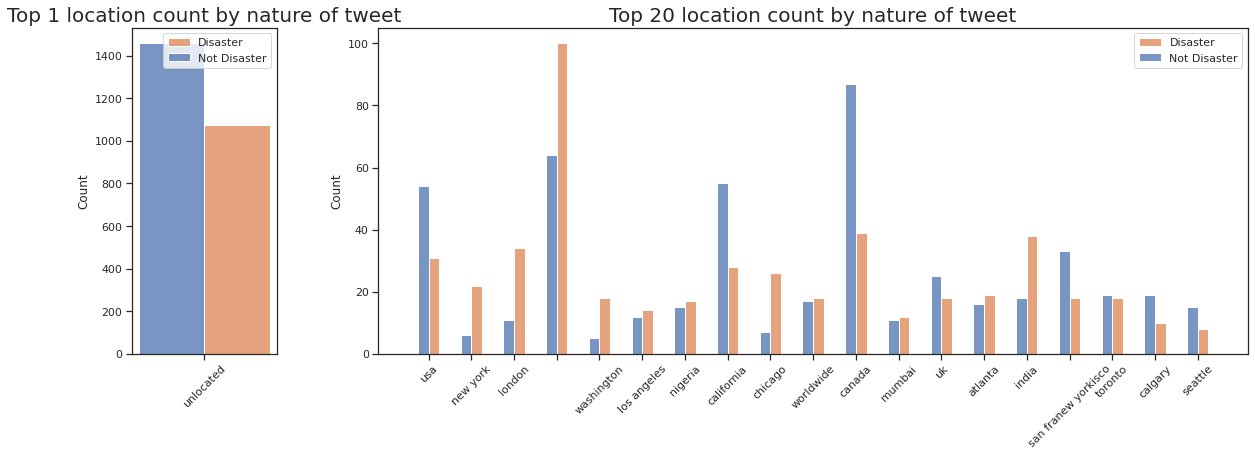

In [ ]:
#Let's take the keyword "unlocated" and process the data separatly from the other keywords
df_top1 = [(keyword,target) for keyword,target in zip(df_train['location'], df_train['target']) if keyword == 'unlocated']
df_top1 = pd.DataFrame(df_top1, columns = ['location', 'target'])

#Let's take the rest of the 20 most frequent keywords
top20 = df_train['location'].value_counts()[1:20].index.tolist()
#We take all the keywords and targets if they are in the top20 list
df_top20 = [(keyword,target) for keyword,target in zip(df_train['location'], df_train['target']) if keyword in top20]
df_top20 = pd.DataFrame(df_top20, columns = ['location', 'target'])

sns.set_theme(style="ticks")

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,6), gridspec_kw={'width_ratios': [1, 6]})

g1 = sns.histplot(data = df_top1, x = 'location', hue = 'target', multiple = 'dodge', shrink = 0.5, ax = ax1)
g1.set_xticklabels(labels = ["unlocated"], rotation = 45)
g1.set_xlabel('')
g1.set_title('Top 1 location count by nature of tweet', fontsize=20)
g1.legend(['Disaster','Not Disaster'],loc="upper right")

g20 = sns.histplot(data = df_top20, x = 'location', hue = 'target', multiple = 'dodge', shrink = 0.5, ax = ax2)
g20.set_xticklabels(labels = top20, rotation=45)
g20.set_xlabel('')
g20.set_title('Top 20 location count by nature of tweet', fontsize=20)
g20.legend(['Disaster','Not Disaster'],loc="upper right")


plt.show()

As we can see the data is cleaner, but as we said earlier we have to get rid of the "unlocated" because there are too many, it will bias the data. Also it's not very useful to keep locations that are used only for few tweets. So we decide to keep only the locations that are used for more than 5 tweets

In [ ]:
#making list of locations used less than 5 times. We will then remove those keywords and the "unlocated aswell"
mask = df_train['location'].value_counts() <5
under_5 = df_train['location'].value_counts()[mask].index.to_list()
df_train['location'] = df_train['location'].apply(lambda x: '' if x in under_5 or x =="unlocated" else x)


#on test
mask = df_test['location'].value_counts() <5
under_5 = df_test['location'].value_counts()[mask].index.to_list()
df_test['location'] = df_test['location'].apply(lambda x: '' if x in under_5 or x =="unlocated" else x)


Finally to use keywords and location  features for our model, we simply add these to our text

In [ ]:
df_train['text'] = df_train['keyword'] + ' ' + df_train['location'] + ' ' + df_train['text']
df_train['text'].head()

#on test 
df_test['text'] = df_test['keyword'] + ' ' + df_test['location'] + ' ' + df_test['text']

# Cleaning the text


Many tweets are duplicated, we don't want to keep these as later when we will split the data, some diplicates might end up in the train set and in the test set aswell. The following functions are largely inspired by these Kaggle notebooks :

 *   https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
 *   https://www.kaggle.com/tuckerarrants/disaster-tweets-eda-glove-rnns-bert


In [ ]:
df_train.loc[df_train['target']==1,'text'].values[0:10]

array(['unknown  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'unknown  Forest fire near La Ronge Sask. Canada',
       "unknown  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       'unknown  13,000 people receive #wildfires evacuation orders in California ',
       'unknown  Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
       'unknown  #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
       'unknown  #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
       "unknown  I'm on top of the hill and I can see a fire in the woods...",
       "unknown  There's an emergency evacuation happening now in the building across the street",
       "unknown  I'm afraid that the tornado is coming to our area..."],
      dtype

## Remove Duplicates

In [ ]:
duplicates = df_train.duplicated(subset = ['text'])
with pd.option_context("display.max_rows", 100, "max_colwidth", 240):
  display(df_train[duplicates])

,id,keyword,location,text,target
48,68,ablaze,,ablaze Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
115,165,aftershock,us,aftershock us 320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0
119,172,aftershock,,aftershock 320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/THyzOMVWU0 | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/83jOO0xk29,0
164,238,airplane%20accident,,airplane%20accident Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on Wednesday began examining t...,1
624,898,bioterrorism,,bioterrorism To fight bioterrorism sir.,0
630,907,bioterrorism,,bioterrorism To fight bioterrorism sir.,1
634,916,bioterrorism,,bioterrorism To fight bioterrorism sir.,0
1725,2488,collided,,collided #Newswatch: 2 vehicles collided at Lock and Lansdowne Sts in #Ptbo. Emerg crews on their way,1
2352,3387,demolition,,demolition General News Û¢åÊ'Demolition of houses on waterways begins at Achimota Mile 7 ' via @233liveOnline. Full story at http://t.co/iO7kUUg1uq,0
2452,3520,derailment,,derailment Madhya Pradesh Train Derailment: Village Youth Saved Many Lives: A group of villagers saved over 70 passengers' lives after two train...,1


In [ ]:
len_before = len(df_train)
df_train = df_train.drop_duplicates(subset = ['text'])
len_after = len(df_train)
print('we deleted', len_before - len_after, 'duplicates')


we deleted 76 duplicates


## Remove emojis

Now let's really get started. We will start by removing emojis

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
df_train['text'] = df_train['text'].apply(lambda x: remove_emoji(x))

## Remove special characters

We then remove special characters and also one thing to note is that we convert every link into the word "http" 

In [ ]:
  def remove_special_char(x):
    #special char
    x = re.sub(r"\x89Û_", "", x)
    x = re.sub(r"\x89ÛÒ", "", x)
    x = re.sub(r"\x89ÛÓ", "", x)
    x = re.sub(r"\x89û", "", x)
    x = re.sub(r"%20", " ", x)
    x = re.sub(r"\x89ûª", "", x)
    x = re.sub(r"\x89û_", "", x)
    x = re.sub(r"\x89ÛÏWhen", "when", x)
    x = re.sub(r"\x89ÛÏ", "", x)
    x = re.sub(r"RÌ©union", "reunion", x)
    x = re.sub(r"Ï", "", x)
    x = re.sub(r"let\x89Ûªs", "let's", x)
    x = re.sub(r"\x89Û÷", "", x)
    x = re.sub(r"\x89Ûª", "", x)
    x = re.sub(r"\x89Û\x9d", "", x)
    x = re.sub(r"å_", "", x)
    x = re.sub(r"ó", "", x)
    x = re.sub(r"ò_", "", x)
    x = re.sub(r"ÛÏ", "", x)
    x = re.sub(r"ÛÒåÊ", "", x)
    x = re.sub(r"Ï", "", x) 
    x = re.sub(r"ÛÒ", "", x)
    x = re.sub(r"ÛÒåÊC", "", x)
    x = re.sub(r"Ï", "", x)
    x = re.sub(r"fvck", "fuck", x)

    x = re.sub(r"Nå¼", "", x)
    x = re.sub(r"åÊ", "", x)
    x = re.sub(r"å ", "", x)

    x = re.sub(r"\x89Û¢", "", x)
    x = re.sub(r"\x89Û¢åÊ", "", x)
    x = re.sub(r"fromåÊwounds", "from wounds", x)
    x = re.sub(r"åÊ", "", x)
    x = re.sub(r"åÈ", "", x)
    x = re.sub(r"JapÌ_n", "Japan", x)    
    x = re.sub(r"Ì©", "e", x)
    x = re.sub(r"å¨", "", x)
    x = re.sub(r"SuruÌ¤", "Suruc", x)
    x = re.sub(r"åÇ", "", x)
    x = re.sub(r"å£3million", "3 million", x)
    x = re.sub(r"åÀ", "", x)
    x = re.sub(r"japì_n", "japan", x)
    x = re.sub(r"Nå¼", " ", x)

    #convert links into the word "http"
    x = re.sub("(http|ftp|https|s||)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?", ' http ',x)

    #remove @mentions 
    x = re.sub(r"@[A-Za-z0-9_]+", " ", x)

    x = re.sub("&amp;", ' and ',x) 
    x = re.sub("&lt;", ' ',x)
    x = re.sub("&gt;", ' ',x)
    x = re.sub("\n", ' ',x)
    x = re.sub("=", ' ',x)
    x = re.sub("ª", ' ',x)
    x = re.sub("\|", ' ',x)
    x = re.sub("~", ' ',x)
    x = re.sub("{", ' ',x)
    x = re.sub("}", ' ',x)
    x = re.sub("\[", ' ',x)
    x = re.sub("\]", ' ',x)
    x = re.sub("\%", ' ',x)
    x = re.sub("\(", ' ',x)
    x = re.sub("\)", ' ',x)
    x = re.sub("\.", ' ',x)
    x = re.sub("\@.", ' ',x)
    x = re.sub("\:.", ' ',x)
    x = re.sub("©", ' ',x)
    x = re.sub("\*", ' ',x)

    #remove multiple punctuation
    x = re.sub(r"\.+", " . ", x)
    x = re.sub(r"\?+", " ? ", x)
    x = re.sub(r"!+", " ! ", x)
    x = re.sub(r"/", " ", x)

    #remove hashtags
    x = re.sub(r"#", " ", x)
    #
    #x = "".join(ch for ch in x if ch.isalnum() or ch == ' ')

    #remove multiple spaces
    x = re.sub(r" +", " ", x)

    #lower
    x = x.lower()

    return x

In [ ]:
df_train['clean_text'] = df_train['text'].apply(lambda x: remove_special_char(x))

## Convert accronyms

In [ ]:
def convert_accronyms(x):    
    #correct some acronyms while we are at it
    x = re.sub(r"tnwx", "Tennessee Weather", x)
    x = re.sub(r"azwx", "Arizona Weather", x)  
    x = re.sub(r"alwx", "Alabama Weather", x)
    x = re.sub(r"wordpressdotcom", "wordpress", x)      
    x = re.sub(r"gawx", "Georgia Weather", x)  
    x = re.sub(r"scwx", "South Carolina Weather", x)  
    x = re.sub(r"cawx", "California Weather", x)
    x = re.sub(r"usNWSgov", "United States National Weather Service", x) 
    x = re.sub(r"MH370", "Malaysia Airlines Flight 370", x)
    x = re.sub(r"okwx", "Oklahoma City Weather", x)
    x = re.sub(r"arwx", "Arkansas Weather", x)  
    x = re.sub(r"lmao", "laughing my ass off", x)  
    x = re.sub(r"amirite", "am I right", x)

    
    #and some typos/abbreviations
    x = re.sub(r"w/e", "whatever", x)
    x = re.sub(r"w/", "with", x)

    #replace some words with multiple occurences of a letter, example "coooool" turns into --> cool
    x = re.sub(r"co+l+", "cool", x)
    x = re.sub(r"l+o+l+", "lol", x)
    x = re.sub(r"g+o+a+l+", "goal", x)
    x = re.sub(r"s+h+i+t+", "shit", x)
    x = re.sub(r"w+t+f+", "wtf", x)
    
    x = re.sub(r"USAgov", "USA government", x)
    x = re.sub(r"recentlu", "recently", x)
    x = re.sub(r"Ph0tos", "Photos", x)
    x = re.sub(r"exp0sed", "exposed", x)
    x = re.sub(r"<3", "love", x)
    x = re.sub(r"amageddon", "armageddon", x)
    x = re.sub(r"Trfc", "Traffic", x)
    x = re.sub(r"WindStorm", "Wind Storm", x)
    x = re.sub(r"16yr", "16 year", x)
    x = re.sub(r"TRAUMATISED", "traumatized", x)
    
    #hashtags and usernames
    x = re.sub(r"IranDeal", "Iran Deal", x)
    x = re.sub(r"ArianaGrande", "Ariana Grande", x)
    x = re.sub(r"camilacabello97", "camila cabello", x) 
    x = re.sub(r"RondaRousey", "Ronda Rousey", x)     
    x = re.sub(r"MTVHottest", "MTV Hottest", x)
    x = re.sub(r"TrapMusic", "Trap Music", x)
    x = re.sub(r"ProphetMuhammad", "Prophet Muhammad", x)
    x = re.sub(r"PantherAttack", "Panther Attack", x)
    x = re.sub(r"StrategicPatience", "Strategic Patience", x)
    x = re.sub(r"socialnews", "social news", x)
    x = re.sub(r"IDPs:", "Internally Displaced People :", x)
    x = re.sub(r"ArtistsUnited", "Artists United", x)
    x = re.sub(r"ClaytonBryant", "Clayton Bryant", x)
    x = re.sub(r"jimmyfallon", "jimmy fallon", x)
    x = re.sub(r"justinbieber", "justin bieber", x)  
    x = re.sub(r"Time2015", "Time 2015", x)
    x = re.sub(r"djicemoon", "dj icemoon", x)
    x = re.sub(r"LivingSafely", "Living Safely", x)
    x = re.sub(r"FIFA16", "Fifa 2016", x)
    x = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", x)
    x = re.sub(r"bbcnews", "bbc news", x)
    x = re.sub(r"UndergroundRailraod", "Underground Railraod", x)
    x = re.sub(r"c4news", "c4 news", x)
    x = re.sub(r"MUDSLIDE", "mudslide", x)
    x = re.sub(r"NoSurrender", "No Surrender", x)
    x = re.sub(r"NotExplained", "Not Explained", x)
    x = re.sub(r"greatbritishbakeoff", "great british bake off", x)
    x = re.sub(r"LondonFire", "London Fire", x)
    x = re.sub(r"KOTAWeather", "KOTA Weather", x)
    x = re.sub(r"LuchaUnderground", "Lucha Underground", x)
    x = re.sub(r"KOIN6News", "KOIN 6 News", x)
    x = re.sub(r"LiveOnK2", "Live On K2", x)
    x = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", x)
    x = re.sub(r"nikeplus", "nike plus", x)
    x = re.sub(r"david_cameron", "David Cameron", x)
    x = re.sub(r"peterjukes", "Peter Jukes", x)
    x = re.sub(r"MikeParrActor", "Michael Parr", x)
    x = re.sub(r"4PlayThursdays", "Foreplay Thursdays", x)
    x = re.sub(r"TGF2015", "Tontitown Grape Festival", x)
    x = re.sub(r"realmandyrain", "Mandy Rain", x)
    x = re.sub(r"GraysonDolan", "Grayson Dolan", x)
    x = re.sub(r"ApolloBrown", "Apollo Brown", x)
    x = re.sub(r"saddlebrooke", "Saddlebrooke", x)
    x = re.sub(r"TontitownGrape", "Tontitown Grape", x)
    x = re.sub(r"AbbsWinston", "Abbs Winston", x)
    x = re.sub(r"ShaunKing", "Shaun King", x)
    x = re.sub(r"MeekMill", "Meek Mill", x)
    x = re.sub(r"TornadoGiveaway", "Tornado Giveaway", x)
    x = re.sub(r"GRupdates", "GR updates", x)
    x = re.sub(r"SouthDowns", "South Downs", x)
    x = re.sub(r"braininjury", "brain injury", x)
    x = re.sub(r"auspol", "Australian politics", x)
    x = re.sub(r"PlannedParenthood", "Planned Parenthood", x)
    x = re.sub(r"calgaryweather", "Calgary Weather", x)
    x = re.sub(r"weallheartonedirection", "we all heart one direction", x)
    x = re.sub(r"edsheeran", "Ed Sheeran", x)
    x = re.sub(r"TrueHeroes", "True Heroes", x)
    x = re.sub(r"ComplexMag", "Complex Magazine", x)
    x = re.sub(r"TheAdvocateMag", "The Advocate Magazine", x)
    x = re.sub(r"CityofCalgary", "City of Calgary", x)
    x = re.sub(r"EbolaOutbreak", "Ebola Outbreak", x)
    x = re.sub(r"SummerFate", "Summer Fate", x)
    x = re.sub(r"RAmag", "Royal Academy Magazine", x)
    x = re.sub(r"offers2go", "offers to go", x)
    x = re.sub(r"ModiMinistry", "Modi Ministry", x)
    x = re.sub(r"TAXIWAYS", "taxi ways", x)
    x = re.sub(r"Calum5SOS", "Calum Hood", x)
    x = re.sub(r"JamesMelville", "James Melville", x)
    x = re.sub(r"JamaicaObserver", "Jamaica Observer", x)
    x = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", x)
    x = re.sub(r"cbplawyers", "cbp lawyers", x)
    x = re.sub(r"fewmoretweets", "few more tweets", x)
    x = re.sub(r"BlackLivesMatter", "Black Lives Matter", x)
    x = re.sub(r"NASAHurricane", "NASA Hurricane", x)
    x = re.sub(r"onlinecommunities", "online communities", x)
    x = re.sub(r"humanconsumption", "human consumption", x)
    x = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", x)
    x = re.sub(r"Meat-Loving", "Meat Loving", x)
    x = re.sub(r"facialabuse", "facial abuse", x)
    x = re.sub(r"LakeCounty", "Lake County", x)
    x = re.sub(r"BeingAuthor", "Being Author", x)
    x = re.sub(r"withheavenly", "with heavenly", x)
    x = re.sub(r"thankU", "thank you", x)
    x = re.sub(r"iTunesMusic", "iTunes Music", x)
    x = re.sub(r"OffensiveContent", "Offensive Content", x)
    x = re.sub(r"WorstSummerJob", "Worst Summer Job", x)
    x = re.sub(r"HarryBeCareful", "Harry Be Careful", x)
    x = re.sub(r"NASASolarSystem", "NASA Solar System", x)
    x = re.sub(r"animalrescue", "animal rescue", x)
    x = re.sub(r"KurtSchlichter", "Kurt Schlichter", x)
    x = re.sub(r"Throwingknifes", "Throwing knives", x)
    x = re.sub(r"GodsLove", "God's Love", x)
    x = re.sub(r"bookboost", "book boost", x)
    x = re.sub(r"ibooklove", "I book love", x)
    x = re.sub(r"NestleIndia", "Nestle India", x)
    x = re.sub(r"realDonaldTrump", "Donald Trump", x)
    x = re.sub(r"DavidVonderhaar", "David Vonderhaar", x)
    x = re.sub(r"CecilTheLion", "Cecil The Lion", x)
    x = re.sub(r"weathernetwork", "weather network", x)
    x = re.sub(r"GOPDebate", "GOP Debate", x)
    x = re.sub(r"RickPerry", "Rick Perry", x)
    x = re.sub(r"frontpage", "front page", x)
    x = re.sub(r"NewsInTweets", "News In Tweets", x)
    x = re.sub(r"ViralSpell", "Viral Spell", x)
    x = re.sub(r"til_now", "until now", x)
    x = re.sub(r"volcanoinRussia", "volcano in Russia", x)
    x = re.sub(r"ZippedNews", "Zipped News", x)
    x = re.sub(r"MicheleBachman", "Michele Bachman", x)
    x = re.sub(r"53inch", "53 inch", x)
    x = re.sub(r"KerrickTrial", "Kerrick Trial", x)
    x = re.sub(r"abstorm", "Alberta Storm", x)
    x = re.sub(r"Beyhive", "Beyonce hive", x)
    x = re.sub(r"RockyFire", "Rocky Fire", x)
    x = re.sub(r"Listen/Buy", "Listen / Buy", x)
    x = re.sub(r"ArtistsUnited", "Artists United", x)
    x = re.sub(r"ENGvAUS", "England vs Australia", x)
    x = re.sub(r"ScottWalker", "Scott Walker", x)

    return x



In [ ]:
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: convert_accronyms(x))

## Expand contractions

expand contractions will also allow out model to have a better comprehension of a tweet

In [ ]:
contractions = { 
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"i'd": "i had / i would",
"i'd've": "i would have",
"i'll": "i shall / i will",
"i'll've": "i shall have / i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}


In [ ]:
contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

In [ ]:
#apply to whole text column
df_train['clean_text'] = df_train['clean_text'].str.lower().apply(lambda x: expand_contractions(x))

In [ ]:
with pd.option_context("display.max_rows", 100, "max_colwidth", 240):
  display(df_train[['text', 'clean_text']])


,text,clean_text
0,unknown Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,unknown our deeds are the reason of this earthquake may allah forgive us all
1,unknown Forest fire near La Ronge Sask. Canada,unknown forest fire near la ronge sask canada
2,unknown All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,unknown all residents asked to 'shelter in place' are being notified by officers no other evacuation or shelter in place orders are expected
3,"unknown 13,000 people receive #wildfires evacuation orders in California","unknown 13,000 people receive wildfires evacuation orders in california"
4,unknown Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,unknown just got sent this photo from ruby alaska as smoke from wildfires pours into a school
...,...,...
7608,unknown Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,unknown two giant cranes holding a bridge coolapse into nearby homes http
7609,unknown @aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,unknown the out of control wild fires in california even in the northern part of the state very troubling
7610,unknown M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,unknown m1 94 01 4 utc ? 5km s of volcano hawaii http
7611,unknown Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,unknown police investigating after an e-bike coolided with a car in little portugal e-bike rider suffered serious non-life threatening injuries


## Convert abbreviations

In [ ]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayyo" : "hello",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dei" : "damn",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "after midday",
  # "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/o" : "without",
    "w/" : "with",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "yr" : "year",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"

 
}

In [ ]:
def convert_abbrev(word):
    word = str(word)
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = text.split()
    tokens = [convert_abbrev(str(word)) for word in tokens]
    text = ' '.join(tokens)
    return text


In [ ]:
#apply to whole text column
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: convert_abbrev_in_text(x))

In [ ]:
#apply to whole text column
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: "".join(ch for ch in x if ch.isalnum() or ch ==' ' or ch =='!' or ch =='?'))

In [ ]:
with pd.option_context("display.max_rows", 100, "max_colwidth", 300):
  display(df_train[['text','clean_text']])


,text,clean_text
0,unknown Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,unknown our deeds are the reason of this earthquake may allah forgive us all
1,unknown Forest fire near La Ronge Sask. Canada,unknown forest fire near la ronge sask canada
2,unknown All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,unknown all residents asked to 'shelter in place' are being notified by officers no other evacuation or shelter in place orders are expected
3,"unknown 13,000 people receive #wildfires evacuation orders in California","unknown 13,000 people receive wildfires evacuation orders in california"
4,unknown Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,unknown just got sent this photo from ruby alaska as smoke from wildfires pours into a school
...,...,...
7608,unknown Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,unknown two giant cranes holding a bridge coolapse into nearby homes http
7609,unknown @aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,unknown the out of control wild fires in california even in the northern part of the state very troubling
7610,unknown M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,unknown m1 94 01 4 coordinated universal time ? 5km s of volcano hawaii http
7611,unknown Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,unknown police investigating after an e-bike coolided with a car in little portugal e-bike rider suffered serious non-life threatening injuries


## Wordclouds

In [ ]:
#df_train['only_text_clean'] = df_train['clean_text'].apply(lambda x: "".join(ch for ch in x if ch.isalnum() or ch ==' '))
#df_train['only_text_clean'] = df_train['only_text_clean'].str.replace(r"http", " " )
#df_train['only_text_clean'] = df_train['only_text_clean'].str.replace(r" +", " " )

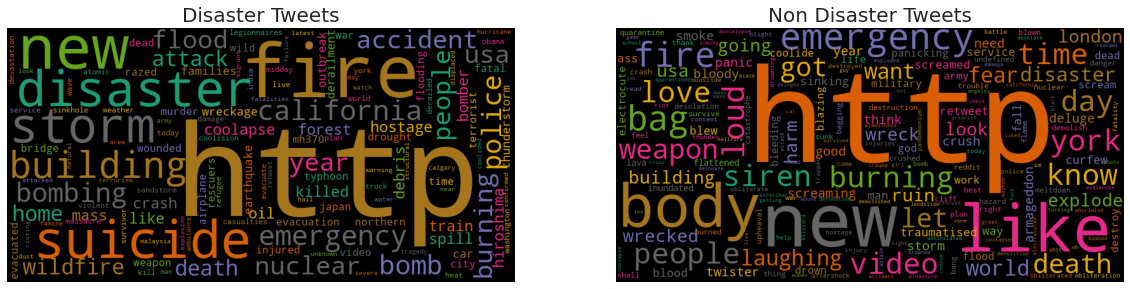

In [ ]:
not_disaster = ' '.join(df_train[df_train['target'] == 0]['clean_text'].str.replace(r" +", " "))
disaster = ' '.join(df_train[df_train['target'] == 1]['clean_text'].str.replace(r" +", " "))

wordcloud_disaster = WordCloud(max_font_size=None,stopwords=STOP_WORDS,scale = 2,colormap = 'Dark2',collocations = False).generate(disaster)
wordcloud_not_disaster = WordCloud(max_font_size=None, stopwords=STOP_WORDS, scale = 2,colormap = 'Dark2',collocations = False).generate(not_disaster)

fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].imshow(wordcloud_disaster)
ax[0].set_title('Disaster Tweets',fontsize = 20)
ax[0].axis("off")

ax[1].imshow(wordcloud_not_disaster)
ax[1].set_title('Non Disaster Tweets',fontsize = 20)
ax[1].axis("off")

plt.show()

# Ngram analysis

It would be useful to make a Ngram Analysis. Ngram They are basically a set of co-occurring words within a given window. Let see what set of words are more frequently used for disaster and non disaster tweets 

In [ ]:
#Function to generate ngrams
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split() if token != '' if token not in STOP_WORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [ ]:
#function to generate ngram dataframes for non disaster and disaster
from collections import defaultdict
def make_ngram_df(df, n_gram = 1, labels=[0,1]):
  df_list = []
  for i in labels:
    Dict = defaultdict(int)
    for tweet in df.loc[df['target'] == i,'clean_text']:
      for word in generate_ngrams(tweet, n_gram = n_gram):
        Dict[word] += 1
    df_n_gram = pd.DataFrame(sorted(Dict.items(), key=lambda x: x[1])[::-1])
    df_list.append(df_n_gram)
  
  return df_list[0], df_list[1] #0 = non disaster, 1 = disaster

In [ ]:
non_disaster_df_unigram, disaster_df_unigram = make_ngram_df(df_train, n_gram = 1) #unigram
non_disaster_df_bigram, disaster_df_bigram = make_ngram_df(df_train, n_gram = 2) # bigram
non_disaster_df_trigram, disaster_df_trigram = make_ngram_df(df_train, n_gram = 3) # trigram
non_disaster_df_fourgram, disaster_df_fourgram = make_ngram_df(df_train, n_gram = 4) # fourgram

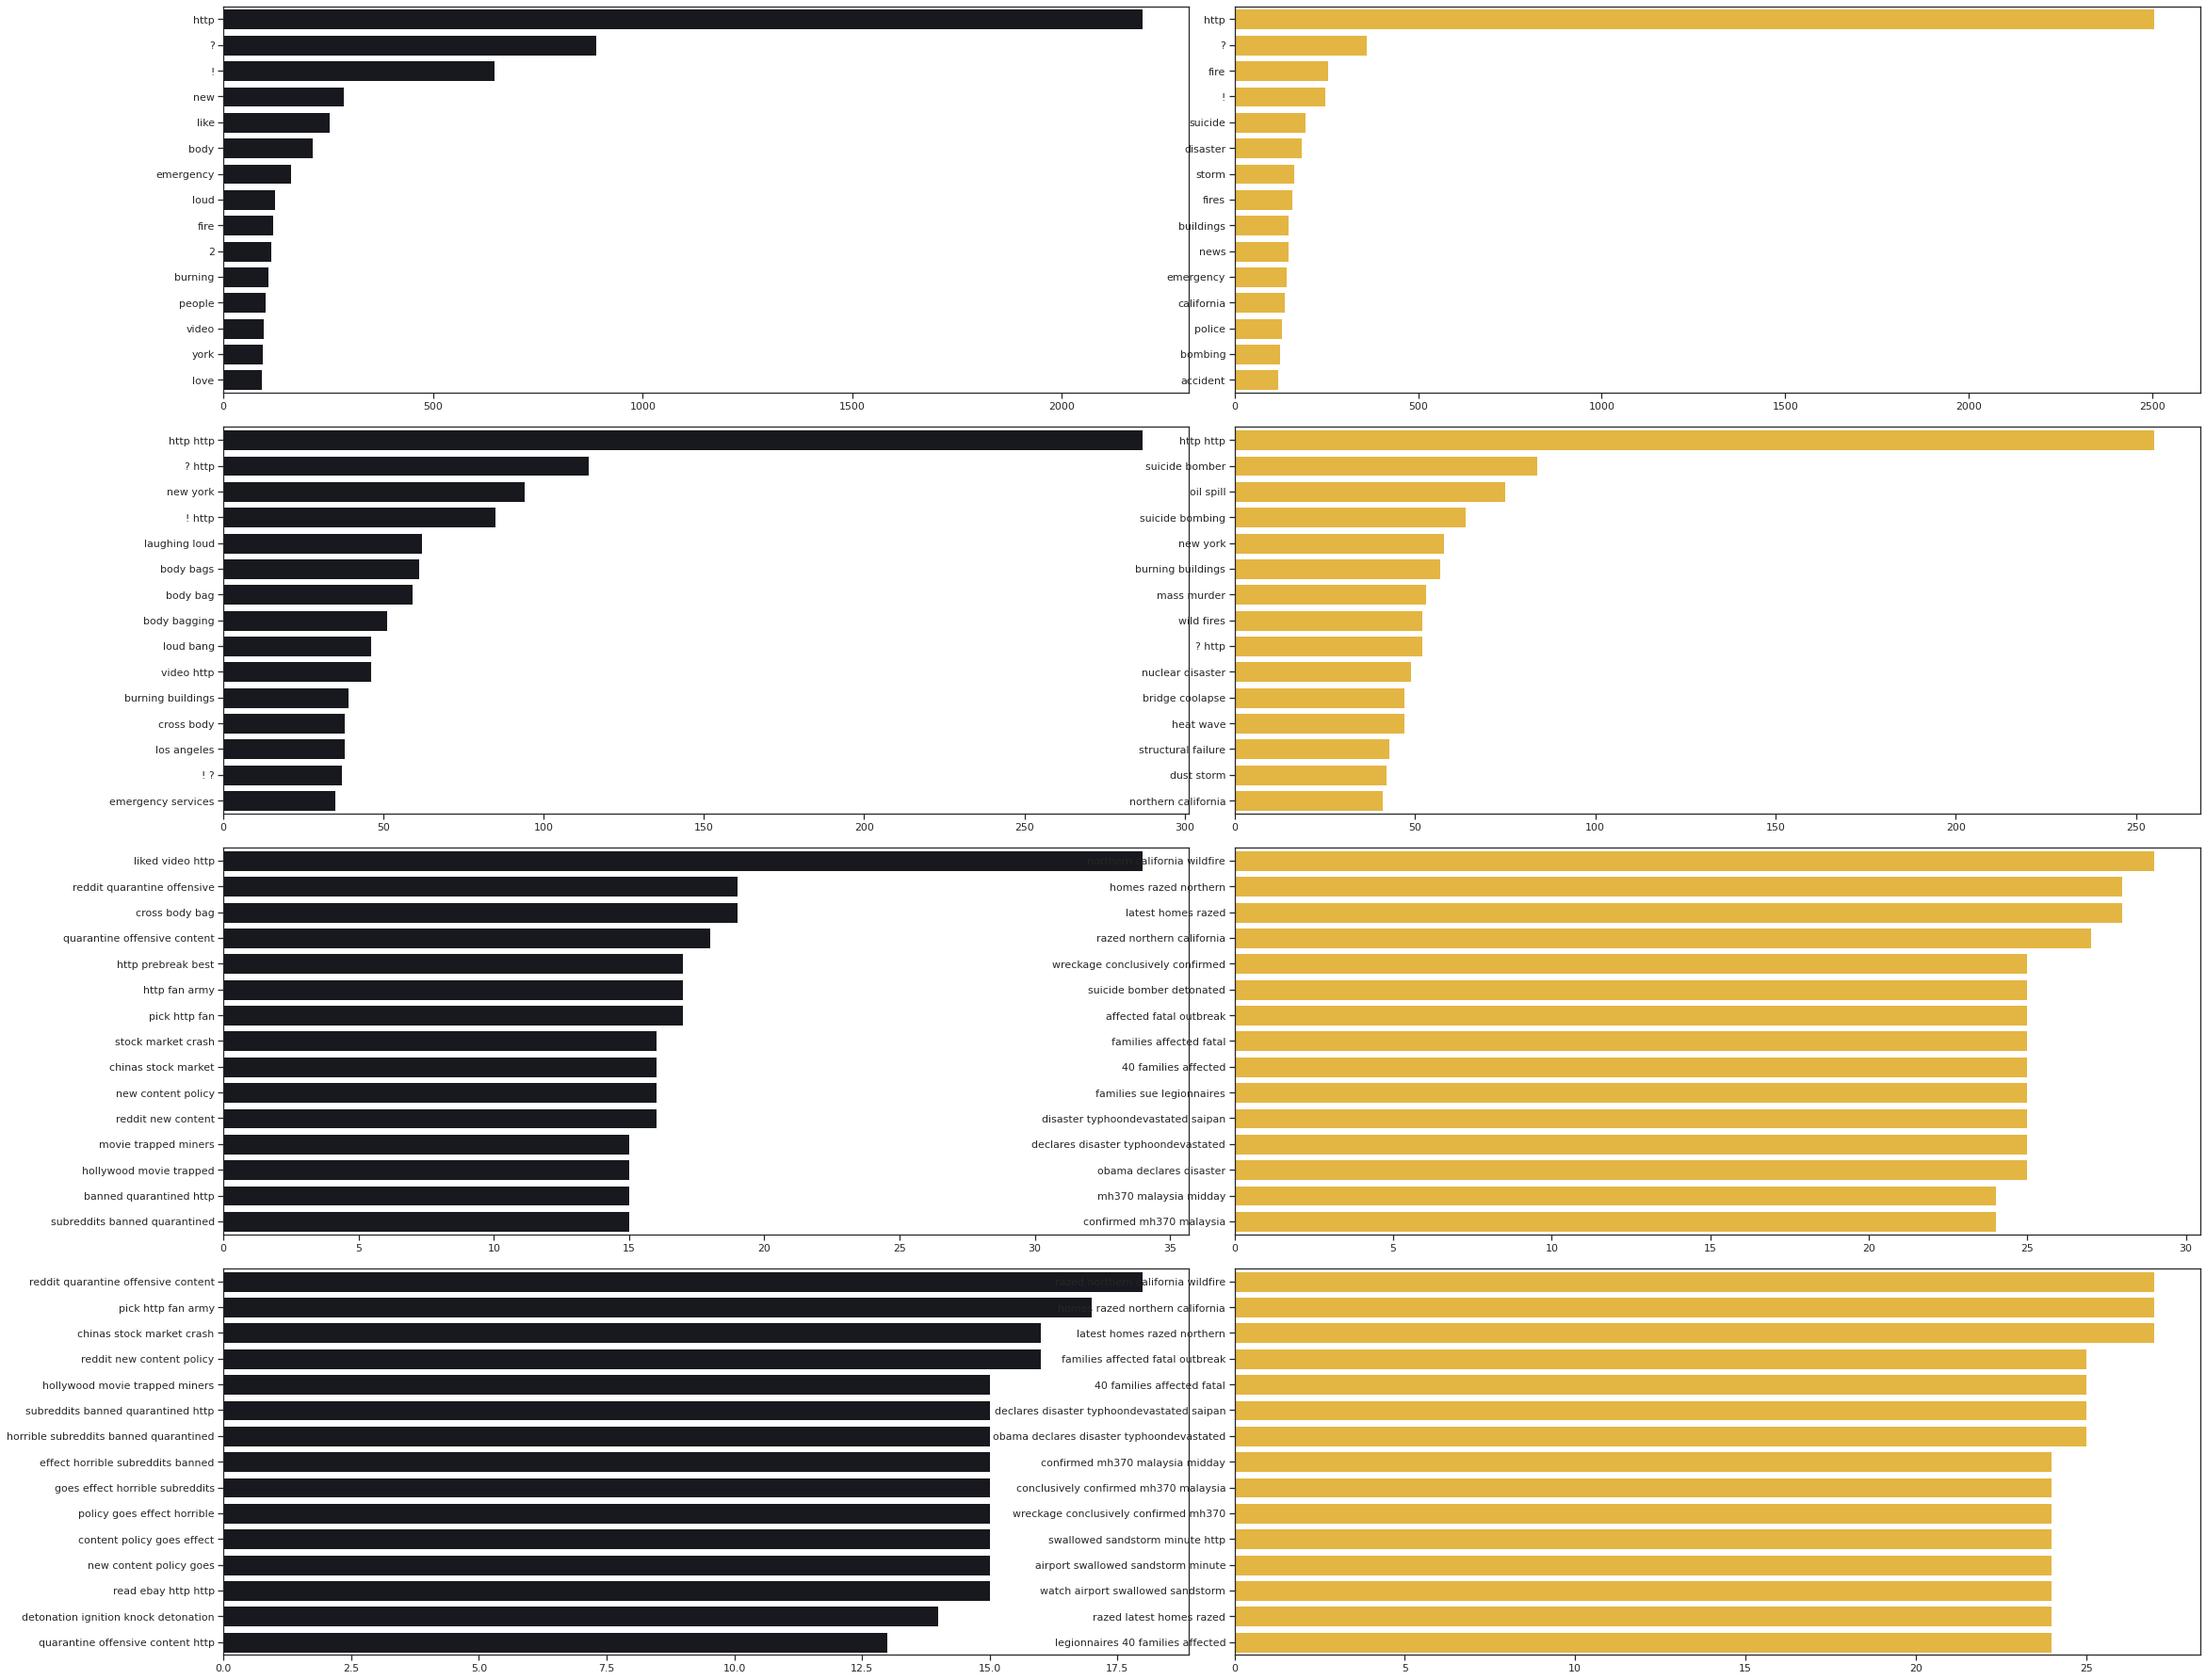

In [ ]:
N = 15

fig, ax = plt.subplots(4, 2, figsize = (30, 25))
plt.tight_layout()
#unigram plots
sns.barplot(y = non_disaster_df_unigram[0].values[:N], x = non_disaster_df_unigram[1].values[:N], ax = ax[0, 0], color='#171820')
sns.barplot(y = disaster_df_unigram[0].values[:N], x = disaster_df_unigram[1].values[:N], ax = ax[0, 1], color = '#fdc029')
#bigram plots
sns.barplot(y = non_disaster_df_bigram[0].values[:N], x = non_disaster_df_bigram[1].values[:N], ax = ax[1, 0], color='#171820')
sns.barplot(y = disaster_df_bigram[0].values[:N], x = disaster_df_bigram[1].values[:N], ax = ax[1, 1], color = '#fdc029')
#trigram plots
sns.barplot(y = non_disaster_df_trigram[0].values[:N], x = non_disaster_df_trigram[1].values[:N], ax = ax[2, 0], color='#171820')
sns.barplot(y = disaster_df_trigram[0].values[:N], x = disaster_df_trigram[1].values[:N], ax = ax[2, 1], color = '#fdc029')
#fourgram plots
sns.barplot(y = non_disaster_df_fourgram[0].values[:N], x = non_disaster_df_fourgram[1].values[:N], ax = ax[3, 0], color='#171820')
sns.barplot(y = disaster_df_fourgram[0].values[:N], x = disaster_df_fourgram[1].values[:N], ax = ax[3, 1], color = '#fdc029')

# Cleaning and Feature Engineering

We create some features that, we believe can emphasize the difference between Disaster and non disasters

In [ ]:
#punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x:  len(''.join(ch for ch in x if ch =='!' or ch == '?')))

#number of digits
df_train['digits'] = df_train['clean_text'].apply(lambda x: len(''.join(ch for ch in x if ch.isnumeric())) )

#mention count
df_train["mention_count"] = df_train["text"].apply(lambda x: len(re.findall("@[A-Za-z0-9_]+", x)) )

#hashtag count
df_train["hashtag_count"] = df_train["text"].apply(lambda x: len(re.findall("#[A-Za-z0-9_]+", x)) )

#link count
df_train['link_count'] = df_train['clean_text'].apply(lambda x: len( [word for word in x.split() if word =='http']) )

#word count
df_train['word_count'] = df_train['clean_text'].apply(lambda x : len(x.split()) )

#tweet len
df_train['tweet_len'] = df_train['clean_text'].apply(lambda x : len(x) )

#Average word length in a tweet
df_train['average_word_length'] = df_train['clean_text'].apply(lambda x : np.mean([len(word) for word in x.split()]) )



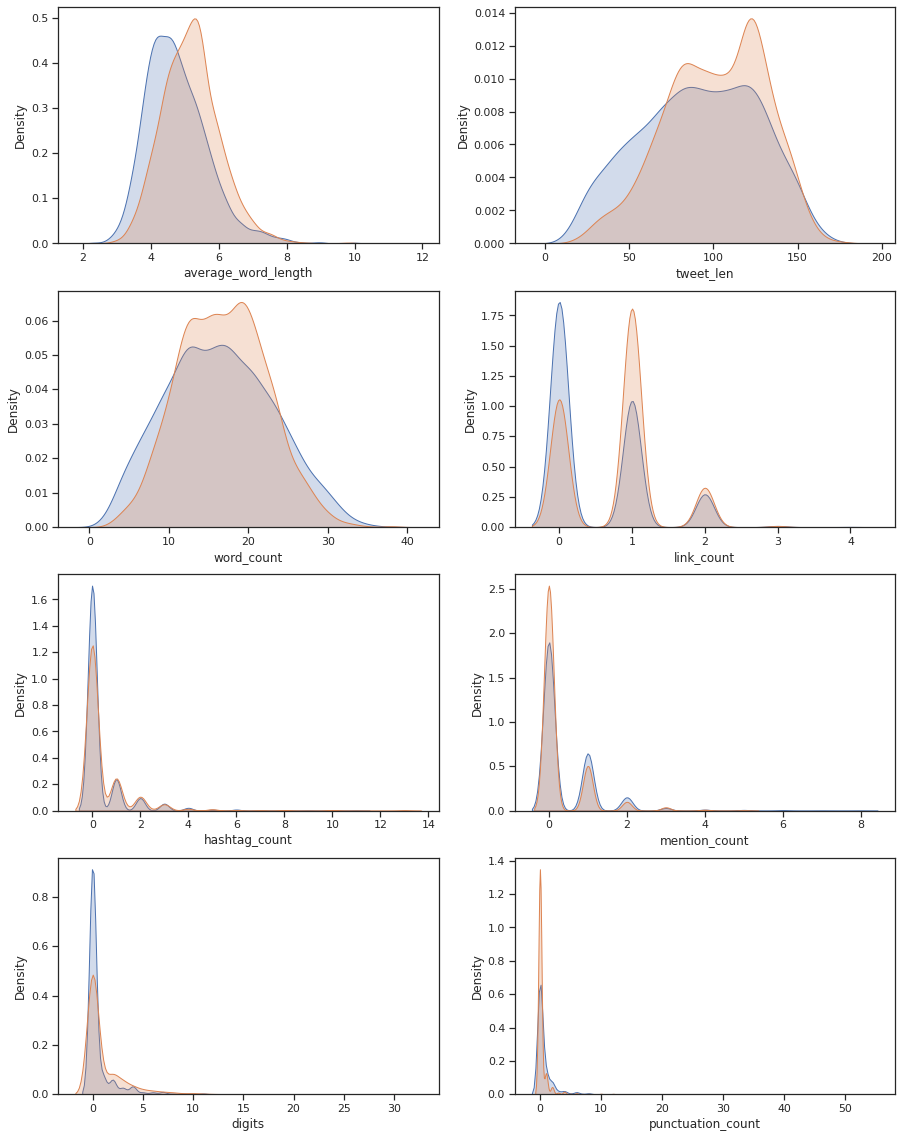

In [ ]:
#define subplot to see graphs side by side
fig, ( (ax1,ax2), (ax3, ax4), (ax5,ax6), (ax7,ax8))  = plt.subplots(4,2, figsize = (15, 20))

#average word length
a=sns.kdeplot(df_train['average_word_length'][df_train['target'] == 0], shade = True, label = 'Not disaster tweet', ax= ax1)
a=sns.kdeplot(df_train['average_word_length'][df_train['target'] == 1], shade = True, label = 'Disaster tweet', ax = ax1)

#tweet len
t=sns.kdeplot(df_train['tweet_len'][df_train['target'] == 0], shade = True, label = 'Not disaster tweet', ax= ax2)
t=sns.kdeplot(df_train['tweet_len'][df_train['target'] == 1], shade = True, label = 'Disaster tweet', ax = ax2)

#word count
w=sns.kdeplot(df_train['word_count'][df_train['target'] == 0], shade = True, label = 'Not disaster tweet', ax= ax3)
w=sns.kdeplot(df_train['word_count'][df_train['target'] == 1], shade = True, label = 'Disaster tweet', ax = ax3)

#link count
l=sns.kdeplot(df_train['link_count'][df_train['target'] == 0], shade = True, label = 'Not disaster tweet', ax= ax4)
l=sns.kdeplot(df_train['link_count'][df_train['target'] == 1], shade = True, label = 'Disaster tweet', ax = ax4)

#hashtag count
h=sns.kdeplot(df_train['hashtag_count'][df_train['target'] == 0], shade = True, label = 'Not disaster tweet', ax= ax5)
h=sns.kdeplot(df_train['hashtag_count'][df_train['target'] == 1], shade = True, label = 'Disaster tweet', ax = ax5)

#mention count
m=sns.kdeplot(df_train['mention_count'][df_train['target'] == 0], shade = True, label = 'Not disaster tweet', ax= ax6)
m=sns.kdeplot(df_train['mention_count'][df_train['target'] == 1], shade = True, label = 'Disaster tweet', ax = ax6)

#number of digits
d=sns.kdeplot(df_train['digits'][df_train['target'] == 0], shade = True, label = 'Not disaster tweet', ax= ax7)
d=sns.kdeplot(df_train['digits'][df_train['target'] == 1], shade = True, label = 'Disaster tweet', ax = ax7)

#punctuation_count
p=sns.kdeplot(df_train['punctuation_count'][df_train['target'] == 0], shade = True, label = 'Not disaster tweet', ax= ax8)
p=sns.kdeplot(df_train['punctuation_count'][df_train['target'] == 1], shade = True, label = 'Disaster tweet', ax = ax8)


#plt.legend()
plt.show()

In [ ]:
df_train.loc[:, ['text', 'clean_text']].sample(15)

,text,clean_text
6691,thunder The thunder shook my house woke my si...,thunder the thunder shook my house woke my sis...
2355,demolition Doing Giveaway Music Kit Dren Deat...,demolition doing giveaway music kit dren death...
3631,fatalities I wonder how Cool/Weird It'll look...,fatalities i wonder how cool weird it shall i...
785,blight maryland @realhotcullen I agree but I k...,blight maryland i agree but i knew we had we ...
2742,devastated @emmerdale I'll be devastated if i...,devastated i shall i will be devastated if it...
645,blaze columbusa @Shayoly yes I love it,blaze coolumbusa yes i love it
4022,forest%20fire I added a video to a @YouTube p...,forest fire i added a video to a playlist http...
6184,sirens @iK4LEN Sirens was cancelled.,sirens sirens was cancelled
922,blown%20up Damn greinke got blown up in that ...,blown up damn greinke got blown up in that fir...
5320,pandemonium Tube strike = absolute pandemonium,pandemonium tube strike absolute pandemonium


In [ ]:
df_test['text'].head()

0          unknown  Just happened a terrible car crash
1    unknown  Heard about #earthquake is different ...
2    unknown  there is a forest fire at spot pond, ...
3    unknown  Apocalypse lighting. #Spokane #wildfires
4    unknown  Typhoon Soudelor kills 28 in China an...
Name: text, dtype: object

In [ ]:
#Cleaning the test set the same way as the train set
df_test['clean_text'] = df_test['text'].apply(lambda x: remove_emoji(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: remove_special_char(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: convert_accronyms(x))
df_test['clean_text'] = df_test['clean_text'].str.lower().apply(lambda x: expand_contractions(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: convert_abbrev_in_text(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: "".join(ch for ch in x if ch.isalnum() or ch ==' ' or ch =='!' or ch =='?'))

In [ ]:
df_test.head()

,id,keyword,location,text,clean_text
0,0,unknown,,unknown Just happened a terrible car crash,unknown just happened a terrible car crash
1,2,unknown,,unknown Heard about #earthquake is different ...,unknown heard about earthquake is different ci...
2,3,unknown,,"unknown there is a forest fire at spot pond, ...",unknown there is a forest fire at spot pond ge...
3,9,unknown,,unknown Apocalypse lighting. #Spokane #wildfires,unknown apocalypse lighting spokane wildfires
4,11,unknown,,unknown Typhoon Soudelor kills 28 in China an...,unknown typhoon soudelor kills 28 in china and...


# Tokenizer Text to Sequences and Train-Test Split

In [ ]:
#We use the whole dataset train+test so that we will capture all the vocabulary with the tokenizer
df_full = pd.concat([df_train['clean_text'], df_test['clean_text']])

#We compute the max length of a sentence
maxlen = df_full.apply(lambda x: len(x.split())).max()
print(maxlen)

#we fit the tokenizer on train and test to have all the vocabulary
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_full)

df_train["review_encoded"] = tokenizer.texts_to_sequences(df_train["clean_text"] )

### we use padding to add up zeros to all our sentences so that they are all the same length
reviews_pad = pd.DataFrame(tf.keras.preprocessing.sequence.pad_sequences(df_train["review_encoded"], padding="post", maxlen = maxlen))

38


In [ ]:
reviews_pad.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,366,116,5639,18,2,845,6,22,163,193,1930,3690,88,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,366,104,29,411,930,8133,8134,415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,366,45,1593,1446,4,2094,5,777,18,164,8135,20,1787,44,465,174,69,2094,5,777,1684,18,1252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,366,3160,64,4410,1373,174,1684,5,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,366,35,112,1517,22,480,24,5640,2778,31,178,24,1373,8136,80,3,404,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Glove

Glove is a very usefull tool when it comes to word embeddings

"GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space"
 
this section is largely inspired by this notebook:
https://www.kaggle.com/tuckerarrants/disaster-tweets-eda-glove-rnns-bert/notebook#Real-or-Not?-NLP-with-Twitter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


I will be using the 300D file
for more information visit this link:
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html


In [ ]:
path = '/content/drive/MyDrive/glove/'
embedding_file = f'{path}/glove.6B.300d.txt'


In [ ]:
# for each line of the file we extract the words wich is the first value and we take the rest of the lines which 
# are the vectors we put all these values in a dict
embeddings_dict = {}
with open(embedding_file, 'r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector


400000it [00:30, 12970.87it/s]


In [ ]:
#for each word in our competition dataset we will get the corresponding 300D glove vector, we will then build an embedding matrix
# with each of these vectors 

word_index = tokenizer.word_index
EMBEDDING_DIM = 300

#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 18593/18593 [00:00<00:00, 490457.44it/s]

Our embedded matrix is of dimension (18594, 300)


We will use this embedding matrix in our embedding layer later when we build our neural network model

# Simple Neural Network

First of all, let's try to run a model that only takes the text into account, later we will try to add up metadata aswell. To start, we have to split our train data into a sub train dataset and a sub test dataset.
So that we can test our model before submitting the results.
We choose to split with the train_test_split method of sklearn because we want to stratify the data. Indeed, we want to keep the same ratio of Disasters/NonDisasters tweets in the subtrain dataset and in the subtest dataset and this function allows us to do that.

## Preprocessing

In [ ]:
y = df_train['target']

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(reviews_pad, y, test_size=0.20, random_state=42, stratify = y)
#We put the subdatasets in Tensorflow dataset allong with their respective targets
train = tf.data.Dataset.from_tensor_slices((X_train_t, y_train_t))
test = tf.data.Dataset.from_tensor_slices((X_test_t, y_test_t))

#We batch, after many tries, 64 seems a good number.
train = train.shuffle(len(train)).batch(64)
test = test.shuffle(len(test)).batch(64)

In [ ]:
#We use the following lines to get the shape of a text element in our tensorflow dataset
for text, label in train.take(1):
  text_input_shape = text.shape[1]
  print(text)


tf.Tensor(
[[  166   191   383 ...     0     0     0]
 [  181  7689  1657 ...     0     0     0]
 [  213    14  1074 ...     0     0     0]
 ...
 [  364   431  1149 ...     0     0     0]
 [  284    83   126 ...     0     0     0]
 [  317   317 14026 ...     0     0     0]], shape=(64, 38), dtype=int32)


In [ ]:
#we get the vocabsize
vocab_size = len(tokenizer.word_index)
vocab_size

18593

## Model Architecture

Now let's build our model. 

* A very important step here is to fill the embedding layer with the 
embedding_matrix we created thanks to glove, it will boost our results. Also we have to make sure that this layers won't train so we just add "trainable=False".
* We also need many Dropout layers to avoid overfitting.
* The Bidirectional layer will make sure that the LSTM will "read" the sentence from left to right and from right to left.

In [ ]:
model = tf.keras.Sequential([
                             
                  #Embedding Layer          
                  tf.keras.layers.Embedding(vocab_size+1, EMBEDDING_DIM, input_shape=[text_input_shape,],
                  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                  trainable=False),

                  tf.keras.layers.Dropout(0.6), 
                  #Bidirectional
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(55, return_sequences=True)),
                  
                  tf.keras.layers.Dropout(0.6),  

                  tf.keras.layers.Flatten(),   
                  
                  #Dense
                  tf.keras.layers.Dense(128, activation='relu'),
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),


                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
 #                 tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer= tf.keras.regularizers.l1(10))
                                              
])

We want to track the accuracy and the f1score aswell, Precision and Recall (which are used to compute f1score) could also be useful. 
As the dataset is imbalanced (more non disasters than disasters), it could be a problem for the training. Adding a class_weight argument will help getting better results.


In [ ]:
df_train['target'].value_counts()

0    4312
1    3225
Name: target, dtype: int64

In [ ]:
4312/3225

1.3370542635658915

In [ ]:

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(num_classes= 1, average= 'macro', threshold=0.5),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]


# We use the Adam optimizer 
optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001,
                                    epsilon=1e-08,
                                    decay=0.01,
                                    clipnorm=1.0)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

class_weight = {
    0:1,
    1:1.337,
}

In [ ]:
#callback to save the best model
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_f1_score',
    mode='max',
    save_best_only=True)



# We train the model
history = model.fit(train, 
                    epochs=15, 
                    validation_data=test,
                    class_weight=class_weight,
                    callbacks=[model_checkpoint_callback]
                    )

Epoch 1/15
95/95 [==============================] - 12s 22ms/step - loss: 0.7369 - accuracy: 0.6509 - f1_score: 0.3769 - precision: 0.5695 - recall: 0.3117 - val_loss: 0.4656 - val_accuracy: 0.7977 - val_f1_score: 0.7712 - val_precision: 0.7471 - val_recall: 0.7969


INFO:tensorflow:Assets written to: /content/checkpoint/assets


INFO:tensorflow:Assets written to: /content/checkpoint/assets


Epoch 2/15
95/95 [==============================] - 1s 13ms/step - loss: 0.5416 - accuracy: 0.7821 - f1_score: 0.7430 - precision: 0.7451 - recall: 0.7411 - val_loss: 0.4345 - val_accuracy: 0.8031 - val_f1_score: 0.7696 - val_precision: 0.7702 - val_recall: 0.7690
Epoch 3/15
95/95 [==============================] - 1s 13ms/step - loss: 0.5310 - accuracy: 0.7869 - f1_score: 0.7515 - precision: 0.7485 - recall: 0.7552 - val_loss: 0.4358 - val_accuracy: 0.8057 - val_f1_score: 0.7744 - val_precision: 0.7691 - val_recall: 0.7798


INFO:tensorflow:Assets written to: /content/checkpoint/assets


INFO:tensorflow:Assets written to: /content/checkpoint/assets


Epoch 4/15
95/95 [==============================] - 1s 13ms/step - loss: 0.5177 - accuracy: 0.7972 - f1_score: 0.7604 - precision: 0.7658 - recall: 0.7552 - val_loss: 0.4183 - val_accuracy: 0.8123 - val_f1_score: 0.7741 - val_precision: 0.7977 - val_recall: 0.7519
Epoch 5/15
95/95 [==============================] - 1s 13ms/step - loss: 0.4974 - accuracy: 0.8069 - f1_score: 0.7667 - precision: 0.7778 - recall: 0.7561 - val_loss: 0.4320 - val_accuracy: 0.8070 - val_f1_score: 0.7790 - val_precision: 0.7634 - val_recall: 0.7953


INFO:tensorflow:Assets written to: /content/checkpoint/assets


INFO:tensorflow:Assets written to: /content/checkpoint/assets


Epoch 6/15
95/95 [==============================] - 1s 14ms/step - loss: 0.4996 - accuracy: 0.8011 - f1_score: 0.7671 - precision: 0.7790 - recall: 0.7561 - val_loss: 0.4163 - val_accuracy: 0.8203 - val_f1_score: 0.7837 - val_precision: 0.8076 - val_recall: 0.7612


INFO:tensorflow:Assets written to: /content/checkpoint/assets


INFO:tensorflow:Assets written to: /content/checkpoint/assets


Epoch 7/15
95/95 [==============================] - 1s 14ms/step - loss: 0.4966 - accuracy: 0.8006 - f1_score: 0.7712 - precision: 0.7859 - recall: 0.7577 - val_loss: 0.4229 - val_accuracy: 0.8190 - val_f1_score: 0.7869 - val_precision: 0.7925 - val_recall: 0.7814


INFO:tensorflow:Assets written to: /content/checkpoint/assets


INFO:tensorflow:Assets written to: /content/checkpoint/assets


Epoch 8/15
95/95 [==============================] - 1s 14ms/step - loss: 0.4807 - accuracy: 0.8172 - f1_score: 0.7795 - precision: 0.7951 - recall: 0.7647 - val_loss: 0.4257 - val_accuracy: 0.8143 - val_f1_score: 0.7843 - val_precision: 0.7795 - val_recall: 0.7891
Epoch 9/15
95/95 [==============================] - 1s 12ms/step - loss: 0.4738 - accuracy: 0.8202 - f1_score: 0.7884 - precision: 0.7950 - recall: 0.7823 - val_loss: 0.4223 - val_accuracy: 0.8203 - val_f1_score: 0.7891 - val_precision: 0.7922 - val_recall: 0.7860


INFO:tensorflow:Assets written to: /content/checkpoint/assets


INFO:tensorflow:Assets written to: /content/checkpoint/assets


Epoch 10/15
95/95 [==============================] - 1s 14ms/step - loss: 0.4929 - accuracy: 0.8120 - f1_score: 0.7749 - precision: 0.7904 - recall: 0.7601 - val_loss: 0.4334 - val_accuracy: 0.8097 - val_f1_score: 0.7811 - val_precision: 0.7688 - val_recall: 0.7938
Epoch 11/15
95/95 [==============================] - 1s 13ms/step - loss: 0.4782 - accuracy: 0.8124 - f1_score: 0.7754 - precision: 0.7883 - recall: 0.7632 - val_loss: 0.4286 - val_accuracy: 0.8163 - val_f1_score: 0.7864 - val_precision: 0.7822 - val_recall: 0.7907
Epoch 12/15
95/95 [==============================] - 1s 13ms/step - loss: 0.4880 - accuracy: 0.8076 - f1_score: 0.7709 - precision: 0.7785 - recall: 0.7636 - val_loss: 0.4200 - val_accuracy: 0.8190 - val_f1_score: 0.7872 - val_precision: 0.7915 - val_recall: 0.7829
Epoch 13/15
95/95 [==============================] - 1s 13ms/step - loss: 0.4776 - accuracy: 0.8213 - f1_score: 0.7782 - precision: 0.7916 - recall: 0.7653 - val_loss: 0.4235 - val_accuracy: 0.8190 - va

INFO:tensorflow:Assets written to: /content/checkpoint/assets


INFO:tensorflow:Assets written to: /content/checkpoint/assets


Epoch 15/15
95/95 [==============================] - 1s 14ms/step - loss: 0.4724 - accuracy: 0.8151 - f1_score: 0.7864 - precision: 0.8025 - recall: 0.7710 - val_loss: 0.4138 - val_accuracy: 0.8223 - val_f1_score: 0.7856 - val_precision: 0.8116 - val_recall: 0.7612


## Prediction on test set and submission

In [ ]:
model = tf.keras.models.load_model('/content/checkpoint')

In [ ]:
### Text to Sequences
df_test["review_encoded"] = tokenizer.texts_to_sequences(df_test["clean_text"] )
### Padding 
reviews_pad_test = pd.DataFrame(tf.keras.preprocessing.sequence.pad_sequences(df_test["review_encoded"], padding="post", maxlen = maxlen))

In [ ]:
threshold = 0.5
y_lstm_proba = model.predict(reviews_pad_test)
y_lstm = [(1 if value > threshold  else 0) for value in y_lstm_proba]

#sample_submission['target'] = np.round(model.predict(reviews_pad_test),0)
sample_submission['target'] = y_lstm
sample_submission['target'] = sample_submission['target'].astype('int')
sample_submission.to_csv('predictions_disaster.csv', index=False)
sample_submission['target'].value_counts()

0    1923
1    1340
Name: target, dtype: int64

# Mixed Data Neural Network - Combining Text and Metadata

## Prepare Metadata

In [ ]:
df_meta = df_train.loc[:, ['punctuation_count', 'digits', 'mention_count', 'hashtag_count', 'link_count', 'word_count', 'tweet_len', 'average_word_length']]
df_meta.head()

,punctuation_count,digits,mention_count,hashtag_count,link_count,word_count,tweet_len,average_word_length
0,0,0,0,1,0,14,76,4.500000
1,0,0,0,0,0,8,45,4.750000
2,0,0,0,0,0,23,138,5.043478
3,0,5,0,1,0,9,70,6.888889
4,0,0,0,2,0,17,93,4.529412


In [ ]:
#We split, and we make sure to have the same random_state as the one we used to split the text, this way the data is split the same way.
X = df_meta
y = df_train['target']

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    stratify = y , 
                                                    random_state = 42)
#we use a scaler from sklearn
scaler = StandardScaler()
X_train_m = scaler.fit_transform(X_train_m)
X_test_m = scaler.transform(X_test_m)

In [ ]:
#split reviews_pad
y = df_train['target']
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(reviews_pad, y, test_size=0.20, random_state=42, stratify = y)

In [ ]:
#We put everything in a tensorflow dataset
train = tf.data.Dataset.from_tensor_slices(({'text': X_train_t, 'metadata': X_train_m }, y_train_t))
test = tf.data.Dataset.from_tensor_slices(({'text': X_test_t, 'metadata': X_test_m }, y_test_t))

train = train.shuffle(len(train)).batch(128)
test = test.shuffle(len(test)).batch(128)

In [ ]:
for data, label in train.take(1):
  text_input_shape = data['text'].shape[1]
  metadata_input_shape = data['metadata'].shape[1]


In [ ]:
vocab_size = len(tokenizer.word_index)
vocab_size

18593

## Model Architecture

In [ ]:
input_text = keras.Input(shape=(text_input_shape,), name="text")  
input_metadata = keras.Input(shape=(metadata_input_shape,), name="metadata")  

# Input Word Embedding, we initialize with the glove embedding matrix and make the layer non trainable
text_features = tf.keras.layers.Embedding(vocab_size+1, EMBEDDING_DIM, input_shape=[text_input_shape,],
                  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                  trainable=False)(input_text)           

text_features = layers.Bidirectional(tf.keras.layers.LSTM(55, return_sequences=True))(text_features)
text_features = layers.Dropout(0.6)(text_features)

text_features = layers.Flatten()(text_features)

#We concatenate both text and metadata here
x_input = layers.concatenate([text_features, input_metadata])

x_features = tf.keras.layers.Dense(64, activation='relu')(x_input)
#x_features = layers.Dropout(0.7)(x_input)
x_features = tf.keras.layers.Dense(32, activation='relu')(x_features)
x_features = tf.keras.layers.Dense(16, activation='relu')(x_features)
x_features = tf.keras.layers.Dense(8, activation='relu')(x_features)

#we put a regularization to limit the overfitting
x_pred= tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l1(0.000006))(x_features)

model = keras.Model(
    inputs=[input_text, input_metadata],
    outputs= x_pred
)


In [ ]:

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(num_classes= 1, average= 'macro', threshold=0.5),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]


# We use the Adam optimizer 
optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0005,
                                    epsilon=1e-08,
                                    decay=0.01,
                                    clipnorm=1.0)


#Compile the model
model.compile(optimizer=optimizer,
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

class_weight = {
    0:1,
    1:1.337,
}


#callback to save the best model
checkpoint_filepath = '/content/checkpoint-mixed'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_f1_score',
    mode='max',
    save_best_only=True)


history = model.fit(train, 
                    epochs=50, 
                    validation_data=test,
                    class_weight=class_weight,
                    callbacks=[model_checkpoint_callback]
                    )

Epoch 1/50
48/48 [==============================] - 6s 35ms/step - loss: 0.7354 - accuracy: 0.6637 - f1_score: 0.4786 - precision: 0.6586 - recall: 0.3915 - val_loss: 0.4815 - val_accuracy: 0.7832 - val_f1_score: 0.7551 - val_precision: 0.7304 - val_recall: 0.7814


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


Epoch 2/50
48/48 [==============================] - 1s 17ms/step - loss: 0.5322 - accuracy: 0.7955 - f1_score: 0.7681 - precision: 0.7528 - recall: 0.7850 - val_loss: 0.4375 - val_accuracy: 0.8103 - val_f1_score: 0.7629 - val_precision: 0.8200 - val_recall: 0.7132


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


Epoch 3/50
48/48 [==============================] - 1s 18ms/step - loss: 0.4856 - accuracy: 0.8147 - f1_score: 0.7743 - precision: 0.7957 - recall: 0.7552 - val_loss: 0.4461 - val_accuracy: 0.7905 - val_f1_score: 0.7599 - val_precision: 0.7452 - val_recall: 0.7752
Epoch 4/50
48/48 [==============================] - 1s 15ms/step - loss: 0.4780 - accuracy: 0.8223 - f1_score: 0.7885 - precision: 0.7964 - recall: 0.7812 - val_loss: 0.4247 - val_accuracy: 0.8143 - val_f1_score: 0.7697 - val_precision: 0.8196 - val_recall: 0.7256


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


Epoch 5/50
48/48 [==============================] - 1s 17ms/step - loss: 0.4652 - accuracy: 0.8304 - f1_score: 0.7901 - precision: 0.8337 - recall: 0.7519 - val_loss: 0.4283 - val_accuracy: 0.8110 - val_f1_score: 0.7747 - val_precision: 0.7903 - val_recall: 0.7597


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


Epoch 6/50
48/48 [==============================] - 1s 17ms/step - loss: 0.4430 - accuracy: 0.8390 - f1_score: 0.8093 - precision: 0.8314 - recall: 0.7884 - val_loss: 0.4179 - val_accuracy: 0.8229 - val_f1_score: 0.7747 - val_precision: 0.8500 - val_recall: 0.7116
Epoch 7/50
48/48 [==============================] - 1s 15ms/step - loss: 0.4548 - accuracy: 0.8336 - f1_score: 0.7973 - precision: 0.8310 - recall: 0.7668 - val_loss: 0.4247 - val_accuracy: 0.8163 - val_f1_score: 0.7782 - val_precision: 0.8046 - val_recall: 0.7535


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


Epoch 8/50
48/48 [==============================] - 1s 17ms/step - loss: 0.4321 - accuracy: 0.8389 - f1_score: 0.8099 - precision: 0.8264 - recall: 0.7944 - val_loss: 0.4237 - val_accuracy: 0.8176 - val_f1_score: 0.7802 - val_precision: 0.8053 - val_recall: 0.7566


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


Epoch 9/50
48/48 [==============================] - 1s 17ms/step - loss: 0.4335 - accuracy: 0.8454 - f1_score: 0.8113 - precision: 0.8457 - recall: 0.7797 - val_loss: 0.4198 - val_accuracy: 0.8236 - val_f1_score: 0.7791 - val_precision: 0.8390 - val_recall: 0.7271
Epoch 10/50
48/48 [==============================] - 1s 14ms/step - loss: 0.4212 - accuracy: 0.8535 - f1_score: 0.8248 - precision: 0.8558 - recall: 0.7960 - val_loss: 0.4208 - val_accuracy: 0.8210 - val_f1_score: 0.7808 - val_precision: 0.8194 - val_recall: 0.7457


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


Epoch 11/50
48/48 [==============================] - 1s 17ms/step - loss: 0.4156 - accuracy: 0.8531 - f1_score: 0.8227 - precision: 0.8484 - recall: 0.7986 - val_loss: 0.4242 - val_accuracy: 0.8190 - val_f1_score: 0.7782 - val_precision: 0.8174 - val_recall: 0.7426
Epoch 12/50
48/48 [==============================] - 1s 15ms/step - loss: 0.4221 - accuracy: 0.8530 - f1_score: 0.8260 - precision: 0.8538 - recall: 0.8001 - val_loss: 0.4218 - val_accuracy: 0.8223 - val_f1_score: 0.7810 - val_precision: 0.8256 - val_recall: 0.7411


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


Epoch 13/50
48/48 [==============================] - 1s 17ms/step - loss: 0.4016 - accuracy: 0.8611 - f1_score: 0.8331 - precision: 0.8646 - recall: 0.8039 - val_loss: 0.4233 - val_accuracy: 0.8196 - val_f1_score: 0.7770 - val_precision: 0.8243 - val_recall: 0.7349
Epoch 14/50
48/48 [==============================] - 1s 15ms/step - loss: 0.4010 - accuracy: 0.8548 - f1_score: 0.8283 - precision: 0.8561 - recall: 0.8024 - val_loss: 0.4210 - val_accuracy: 0.8210 - val_f1_score: 0.7750 - val_precision: 0.8378 - val_recall: 0.7209
Epoch 15/50
48/48 [==============================] - 1s 15ms/step - loss: 0.4071 - accuracy: 0.8612 - f1_score: 0.8287 - precision: 0.8705 - recall: 0.7912 - val_loss: 0.4284 - val_accuracy: 0.8210 - val_f1_score: 0.7854 - val_precision: 0.8059 - val_recall: 0.7659


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


INFO:tensorflow:Assets written to: /content/checkpoint-mixt/assets


Epoch 16/50
48/48 [==============================] - 2s 32ms/step - loss: 0.3906 - accuracy: 0.8675 - f1_score: 0.8415 - precision: 0.8671 - recall: 0.8174 - val_loss: 0.4326 - val_accuracy: 0.8183 - val_f1_score: 0.7836 - val_precision: 0.7987 - val_recall: 0.7690
Epoch 17/50
48/48 [==============================] - 1s 15ms/step - loss: 0.3876 - accuracy: 0.8632 - f1_score: 0.8369 - precision: 0.8622 - recall: 0.8131 - val_loss: 0.4277 - val_accuracy: 0.8229 - val_f1_score: 0.7849 - val_precision: 0.8171 - val_recall: 0.7550
Epoch 18/50
48/48 [==============================] - 1s 14ms/step - loss: 0.3922 - accuracy: 0.8605 - f1_score: 0.8353 - precision: 0.8518 - recall: 0.8195 - val_loss: 0.4284 - val_accuracy: 0.8223 - val_f1_score: 0.7853 - val_precision: 0.8126 - val_recall: 0.7597
Epoch 19/50
48/48 [==============================] - 1s 14ms/step - loss: 0.3880 - accuracy: 0.8627 - f1_score: 0.8395 - precision: 0.8646 - recall: 0.8160 - val_loss: 0.4247 - val_accuracy: 0.8190 - va

## Prediction on test set - Mixed data

We have to do the exact same preprocessing on the test that the ones we used for the train

In [ ]:
### Text to Sequences
df_test["review_encoded"] = tokenizer.texts_to_sequences(df_test["clean_text"] )
### Padding 
reviews_pad_test = pd.DataFrame(tf.keras.preprocessing.sequence.pad_sequences(df_test["review_encoded"], padding="post", maxlen= maxlen))


#punctuation_count
df_test['punctuation_count'] = df_test['text'].apply(lambda x:  len(''.join(ch for ch in x if ch =='!' or ch == '?')))
#number of digits
df_test['digits'] = df_test['clean_text'].apply(lambda x: len(''.join(ch for ch in x if ch.isnumeric())) )
#mention count
df_test["mention_count"] = df_test["text"].apply(lambda x: len(re.findall("@[A-Za-z0-9_]+", x)) )
#hashtag count
df_test["hashtag_count"] = df_test["text"].apply(lambda x: len(re.findall("#[A-Za-z0-9_]+", x)) )
#link count
df_test['link_count'] = df_test['clean_text'].apply(lambda x: len( [word for word in x.split() if word =='http']) )
#word count
df_test['word_count'] = df_test['clean_text'].apply(lambda x : len(x.split()) )
#tweet len
df_test['tweet_len'] = df_test['clean_text'].apply(lambda x : len(x) )
#Average word length in a tweet
df_test['average_word_length'] = df_test['clean_text'].apply(lambda x : np.mean([len(word) for word in x.split()]) )


df_meta = df_test.loc[:, ['punctuation_count', 'digits', 'mention_count', 'hashtag_count', 'link_count', 'word_count', 'tweet_len', 'average_word_length']]

print(df_meta.shape)

# Preprocessings on test set
X_m = scaler.transform(df_meta) 

print(X_m.shape)


(3263, 8)
(3263, 8)


In [ ]:
model = tf.keras.models.load_model('/content/checkpoint-mixed')

In [ ]:
threshold = 0.5
y_prob_mixed  = model.predict({'text':reviews_pad_test, 'metadata': X_m})
y_mixed = [(1 if value > threshold  else 0) for value in y_prob_mixed ]

In [ ]:
sample_submission['target'] = y_mixed
sample_submission['target'] = sample_submission['target'].astype('int')
sample_submission.to_csv('predictions_disaster.csv', index=False)
sample_submission['target'].value_counts()

0    1958
1    1305
Name: target, dtype: int64

# BERT

## Model Architecture and preprocessing

In [ ]:
!pip install transformers
!pip install bert
!pip install tokenization
from transformers import TFBertModel, BertTokenizerFast, BertConfig
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import bert
#from bert import tokenization

     |████████████████████████████████| 1.8 MB 17.0 MB/s 
     |████████████████████████████████| 3.2 MB 69.3 MB/s 
     |████████████████████████████████| 883 kB 65.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893258 sha256=83bb10cef29ebc162645e263fc3f748d008d2caeff9c416b8ef471bd7dea90e1
  Stored in directory: /root/.cache/pip/wheels/49/25/98/cdea9c79b2d9a22ccc59540b1784b67f06b633378e97f58da2
Successfully built sacremoses
  Created wheel for bert: filename=bert-2.2.0-py3-none-any.whl size=3753 sha256=b030508650de4b8cbda3c6cf51d55987eae598330dcece40aa1988d066eee69e
  Stored in directory: /root/.cache/pip/wheels/cb/da/90/bc3128c1676721ede415ed707464c4ea5671ee3e292e6b5404
  Created wheel for erlastic: filename=erlastic-2.0.0-py3-none-any.whl size=6788 sha256=58d93739a88a88a5f8474e3b401d6a978b43455308f3b20b057465906b3f6726
  Stored in directory: /root/.cache/pip/wheels/10/bb/e1/a8f26a46f7f4d9278a50c924b93a1664e95db12b0d785da5b4
Successfully buil

In [ ]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from transformers import TFRobertaModel, RobertaTokenizer, RobertaConfig

In [ ]:
full_text = pd.concat([df_train['clean_text'], df_test['clean_text']])
max_length = full_text.apply(lambda x: len(x.split())).max()
max_length

38

In [ ]:
model_name = 'bert-base-uncased'
#model_name = 'roberta-base'

config = BertConfig.from_pretrained(model_name)
#config = RobertaConfig.from_pretrained(model_name)

config.output_hidden_states = False

tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
#tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

#transformer_model = TFRobertaModel.from_pretrained(model_name, config = config)
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Load the MainLayer
bert = transformer_model.layers[0]
# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
token_ids = Input(shape=(max_length,), name='token_ids', dtype='int32')
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask, 'token_ids': token_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)
# Then build your model output
issue = Dense(units=1, activation="sigmoid" , kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='issue')(pooled_output)
outputs = issue
# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')
# Take a look at the model
model.summary()

Model: "BERT_MultiLabel_MultiClass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 38)]         0                                            
__________________________________________________________________________________________________
token_ids (InputLayer)          [(None, 38)]         0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   attention_mask[0][0]             
                                                                 input_id

In [ ]:
#We Split with stratify 
y = df_train['target']
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(df_train['clean_text'], y, test_size=0.20, random_state=42, stratify = y)

#we use the Bert tokenizer for the train
train = tokenizer(
    text=X_train_t.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

#Same for test
test = tokenizer(
    text=X_test_t.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

In [ ]:
train={'input_ids': train['input_ids'], 'attention_mask': train['attention_mask'],'token_ids': train['token_type_ids']}
test={'input_ids': test['input_ids'], 'attention_mask': test['attention_mask'],'token_ids': test['token_type_ids']}

In [ ]:
train = tf.data.Dataset.from_tensor_slices((train, y_train_t)).shuffle(len(train)).batch(64)
test = tf.data.Dataset.from_tensor_slices((test, y_test_t)).shuffle(len(test)).batch(64)

In [ ]:
# Set an optimizer
optimizer = Adam(
    learning_rate=1e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics

loss = tf.keras.losses.BinaryCrossentropy()

metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(num_classes= 1, average= 'macro', threshold=0.5),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metrics)


#callback to save the best model
checkpoint_filepath = '/content/checkpoint-bert'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_f1_score',
    mode='max',
    save_best_only=True)

class_weight = {
    0:1,
    1:1.337,
}

history = model.fit(train, 
                    epochs=10, 
                    validation_data=test,
                    class_weight=class_weight,
                    callbacks=[model_checkpoint_callback]
                    )

Epoch 1/10
95/95 [==============================] - 69s 567ms/step - loss: 0.6781 - accuracy: 0.7082 - f1_score: 0.6092 - precision: 0.6638 - recall: 0.5865 - val_loss: 0.4653 - val_accuracy: 0.8084 - val_f1_score: 0.7838 - val_precision: 0.7572 - val_recall: 0.8124


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


Epoch 2/10
95/95 [==============================] - 52s 553ms/step - loss: 0.4985 - accuracy: 0.8231 - f1_score: 0.7857 - precision: 0.8068 - recall: 0.7668 - val_loss: 0.4199 - val_accuracy: 0.8309 - val_f1_score: 0.8031 - val_precision: 0.8000 - val_recall: 0.8062


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


Epoch 3/10
95/95 [==============================] - 53s 553ms/step - loss: 0.4474 - accuracy: 0.8448 - f1_score: 0.8109 - precision: 0.8372 - recall: 0.7870 - val_loss: 0.4176 - val_accuracy: 0.8302 - val_f1_score: 0.8034 - val_precision: 0.7960 - val_recall: 0.8109


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


Epoch 4/10
95/95 [==============================] - 53s 554ms/step - loss: 0.4194 - accuracy: 0.8615 - f1_score: 0.8314 - precision: 0.8584 - recall: 0.8068 - val_loss: 0.4368 - val_accuracy: 0.8276 - val_f1_score: 0.8036 - val_precision: 0.7835 - val_recall: 0.8248


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


Epoch 5/10
95/95 [==============================] - 52s 544ms/step - loss: 0.4042 - accuracy: 0.8639 - f1_score: 0.8353 - precision: 0.8564 - recall: 0.8162 - val_loss: 0.4146 - val_accuracy: 0.8349 - val_f1_score: 0.8068 - val_precision: 0.8075 - val_recall: 0.8062


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


Epoch 6/10
95/95 [==============================] - 51s 535ms/step - loss: 0.3874 - accuracy: 0.8717 - f1_score: 0.8436 - precision: 0.8713 - recall: 0.8180 - val_loss: 0.4191 - val_accuracy: 0.8355 - val_f1_score: 0.8078 - val_precision: 0.8078 - val_recall: 0.8078


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


Epoch 7/10
95/95 [==============================] - 51s 533ms/step - loss: 0.3794 - accuracy: 0.8761 - f1_score: 0.8492 - precision: 0.8768 - recall: 0.8234 - val_loss: 0.4158 - val_accuracy: 0.8382 - val_f1_score: 0.8100 - val_precision: 0.8138 - val_recall: 0.8062


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


Epoch 8/10
95/95 [==============================] - 50s 529ms/step - loss: 0.3623 - accuracy: 0.8870 - f1_score: 0.8618 - precision: 0.8939 - recall: 0.8320 - val_loss: 0.4220 - val_accuracy: 0.8369 - val_f1_score: 0.8090 - val_precision: 0.8103 - val_recall: 0.8078
Epoch 9/10
95/95 [==============================] - 52s 543ms/step - loss: 0.3609 - accuracy: 0.8875 - f1_score: 0.8626 - precision: 0.8916 - recall: 0.8358 - val_loss: 0.4175 - val_accuracy: 0.8382 - val_f1_score: 0.8085 - val_precision: 0.8188 - val_recall: 0.7984
Epoch 10/10
95/95 [==============================] - 52s 546ms/step - loss: 0.3527 - accuracy: 0.8940 - f1_score: 0.8704 - precision: 0.9024 - recall: 0.8406 - val_loss: 0.4206 - val_accuracy: 0.8395 - val_f1_score: 0.8106 - val_precision: 0.8183 - val_recall: 0.8031


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


INFO:tensorflow:Assets written to: /content/checkpoint-bert/assets


## Prediction on test set and submission

In [ ]:
x_test = tokenizer(
        text=df_test['clean_text'].to_list(),
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding=True, 
        return_tensors='tf',
        return_token_type_ids = True,
        return_attention_mask = True,
        verbose = True)

In [ ]:
model = tf.keras.models.load_model('/content/checkpoint-bert')

In [ ]:
y_pred = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'],'token_ids': x_test['token_type_ids']})

In [ ]:
threshold = 0.5
y_bert = [(1 if value > threshold  else 0) for value in y_pred]


In [ ]:
#sample_submission['target'] = np.argmax(pred['issue'], axis=1)
sample_submission['target'] = y_bert
sample_submission['target'] = sample_submission['target'].astype('int')
sample_submission.to_csv('predictions_disaster_tweet.csv', index=False)
sample_submission['target'].value_counts()

0    1896
1    1367
Name: target, dtype: int64